purpose: to look at MAGMA S2G mapping for rats and humans and compare the output and signal
 - manhattan plots
 - qq plots
 - histograms of pvalues
datasets looked at:
 - rat:
     - run 1 traits:
         - locomotor activity
             - window size optimization for locomotor (using N=8.9k, which I think actually should have been 7.7k, but I won't rerun until I have the final dataset for loco)
             - rerun 10kb window using 7.7k rats (actualy number of phenotyped rats, not genotyped, as Hao Chen's dataset was removed)
             - as of 1 August 2024, all results have been calculated with 8.9k rats. However, checking the seed genes (below) shows that FDR and bonferroni cutoffs did not lead to different genes based on cutoff so all network analysis does not need to be rerun.
         - PCA analysis of NICSA traits using traits recommended by hao chen
     - PCA analysis run 2 for NICSA traits using QTLs and with and all traits with QTLs
 - human:
     - externalizing1.0 (2019)

# set-up

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest
import statsmodels.api as sm 
import pylab as py 
import statsmodels.api as sm
from scipy.stats import pearsonr
import seaborn as sb
import ndex2
import networkx as nx
os.chdir('/tscc/projects/ps-palmer/brittany/rare_common_alcohol/rare_common_alcohol_comparison/notebooks/')
from rca_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/scripts')
from network_functions import *
from network_validation_functions import *
from plotting_functions import *
os.chdir('/tscc/projects/ps-palmer/brittany/SUD_cross_species/')

In [2]:
plt.rcParams.update({'font.size': 12})

In [3]:
save_fig=True

# import files

## SNP level results

In [4]:
nicsa_gwas_dir='/tscc/projects/ps-palmer/brittany/SUD_cross_species/nicsa_gwas_pc1/results/gwas/mlma_concat/'
snp_dict={
    'loco':pd.read_csv('loco_meta/regressedlr_combined_locomotor.mlma', sep='\t'),
    'ext':pd.read_csv('ext_sumstat_2019/FINAL.EXT_COMMON_FACTOR.EXTERNALIZING.20191014.PREPARED.wFREQ.A1.txt.gz',compression='gzip',delim_whitespace=True),
    'addict-rf':pd.read_csv('gwas_ctrl_hm/hatoum_addiction_euro_2023.txt.gz',compression='gzip',sep='\t'),
    'loco_final_cf':pd.read_csv('loco_final/mlma_concat/regressedlr_gsem_results_commonfactor_F1_common_chrgwas.mlma',sep='\t'),
    'loco_final_mega':pd.read_csv('loco_final/mlma_concat/regressedlr_gsem_results_commonfactor_F1_common_chrgwas.mlma',sep='\t')    
}

## gene level results

### locomotor window size

In [7]:
#locomotor- all window sizes
#win=[0,1,5,10,25,50, 100, 250]
loco={}
for x in win:    
    loco[x]=pd.read_csv('magma/loco_meta_win'+str(x)+'.genes.out', delim_whitespace=True,index_col=None,skiprows=1)
    loco[x]['Q']=statsmodels.stats.multitest.fdrcorrection(loco[x]['P'],alpha=0.05,method='indep',is_sorted=False)[1]

### all traits

In [25]:
magma_dict={}
for k in file_dict.keys():
    if not ( ('fus' in k) or ('ext_st22' in k) ):
        magma_dict[k]=pd.read_csv(file_dict[k],sep='\t')

In [26]:
magma_dict.keys()

dict_keys(['loco', 'loco_gsem', 'ext', 'loco_final_cf', 'loco_final_mega', 'ext_rat', 'loco_final_cf_rat', 'ext_db', 'ext_rtb'])

In [5]:
'''magma_dict={
    #'cigday_pc1':pd.read_csv('magma/cigday_pc1_nicsa_geno.genes.out',delim_whitespace=True,index_col=None,skiprows=1),
    #'smkinit_pc1':pd.read_csv('magma/smkinit_pc1_nicsa_geno.genes.out',delim_whitespace=True,index_col=None,skiprows=1),
    #'loco':pd.read_csv('magma/loco_meta_7k_win10.genes.out', delim_whitespace=True,index_col=None,skiprows=1),
    'loco':pd.read_csv('magma/loco_gsem_7k_win10.genes.out', delim_whitespace=True,index_col=None,skiprows=1), 
    'ext':pd.read_csv('magma/seed_genes/ext_orig_annot.tsv',sep='\t'),
    #'ext_munged':pd.read_csv('magma/seed_genes/ext_munged_annot.tsv',sep='\t'),
    'loco_final_cf':pd.read_csv('magma/seed_genes/loco_final_cf_win10_annot.tsv',sep='\t'),
    'loco_final_mega':pd.read_csv('magma/seed_genes/loco_final_mega_win10_annot.tsv',sep='\t'),
}'''

In [7]:
snp_dict.keys()

dict_keys(['loco', 'ext', 'addict-rf', 'loco_final_cf', 'loco_final_mega'])

# human control traits

In [11]:
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    magma_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')

In [27]:
for k in magma_dict.keys():
    print(k)
    magma_dict[k]['Q']=statsmodels.stats.multitest.fdrcorrection(magma_dict[k]['P'],alpha=0.05,method='indep',is_sorted=False)[1]

loco
loco_gsem
ext
loco_final_cf
loco_final_mega
ext_rat
loco_final_cf_rat
ext_db
ext_rtb


# define functions

In [28]:
def qqplot_gwas(pvals,c,savefig=False,filename='qqplot', title=None, xmax=None, ymax=None):

    # Calculate theoretical p-values
    n = len(pvals)
    expected = -np.log10((np.arange(1, n + 1) / (n + 1)))
    
    # Sort the observed p-values
    observed = -np.log10(np.sort(pvals))

    # Create the Q-Q plot
    plt.figure(figsize=(4, 4))
    plt.plot(expected, observed, 'o', label='Observed p-values',color=c)
    plt.plot([0, max(expected)], [0, max(expected)], 'k-', label='Expected (null)')
    plt.xlabel('expected -log10(p)')
    plt.ylabel('observed -log10(p)')
    if xmax!=None:
        plt.xlim(0,7)
    if ymax !=None:
        plt.ylim(0,7)
    if (title!=None):
        plt.title(title)

    if(savefig):
       plt.savefig('figures/'+filename+'.png',dpi=600,bbox_inches='tight') 
    plt.show()

# Example usage
# qqplot_gwas(pvals, qtltable, col2use, tnum, d, save=True, path='/your/path/')


In [29]:
def corr_plt(x,y,stat='p'):
    if stat=='p':
        x=-np.log10(x)
        y=-np.log10(y)
    corr='%s' % float('%.2g' % pearsonr(x,y)[0])
    fig=plt.figure(figsize=(4,4))
    if stat=='p':
        fig=plt.plot([0, 10], [0, 10], color='black', linestyle='--')
    else:
        fig=plt.plot([-3, 10], [-3, 10], color='black', linestyle='--')
        fig=plt.axhline(y=0, color='black', linestyle='--')
        fig=plt.axvline(x=0, color='black', linestyle='--')
    fig=plt.scatter(x,y,color=colour_dict['loco'])
    fig=plt.title(str(w)+' kb window vs '+str(w2)+' kb window, corr='+str(corr))
    if stat=='p':
        fig=plt.xlabel('-log10(p) ('+ str(w)+ ' kb win)')
        fig=plt.ylabel('-log10(p) ('+ str(w2)+ ' kb win)')
    elif stat=='z':
        fig=plt.xlabel('ZSTAT ('+ str(w)+ ' kb win)')
        fig=plt.ylabel('ZSTAT ('+ str(w2)+ ' kb win)')
    return(corr)

# Interactome Set-up

pcnet2- versions 
from wright et al. 2024 preprint:
PCNet 2.0= best-performing ranked composite (top 15 interactomes, 3.85M interactions)
PCNet 2.1= top 8 interactomes, 1.75M interactions
PCNet 2.2= top 10 co-citation-free interactomes, 3.32M interactions 

In [10]:
interactome_name='PCNet2.0'

In [11]:
graph=import_interactome(UUIDs=UUIDs,interactome_name=interactome_name)
all_nodes=list(graph.nodes())

PCNet2.0
Name: PCNet 2.0
Nodes: 19267
Edges: 3852119
Node Attributes: 19267
Edge Attributes: 19260595

number of nodes:
19267

number of edges:
3852119


# plot GWAS pvalue comparison

## histogram pvalues- for ratxcan comparison

### locomotor

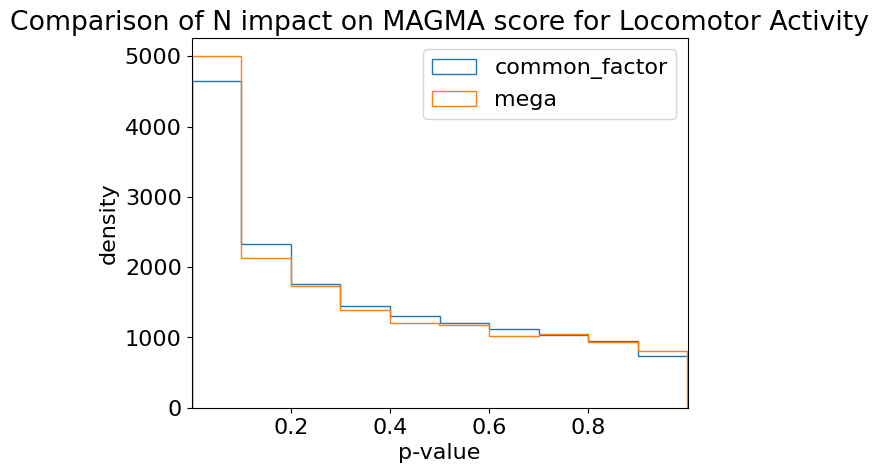

In [31]:
k='MAGMA'
plt.hist(magma_dict['loco_final_cf'].P,histtype='step', stacked=True, fill=False,label='common_factor')
plt.hist(magma_dict['loco_final_mega'].P,histtype='step', stacked=True, fill=False,label='mega')

fig=plt.title('Comparison of analysis method vs MAGMA score for Locomotor Activity')
fig=plt.xlabel('p-value')
fig=plt.ylabel('density')
fig=plt.legend()
plt.margins(x=0)

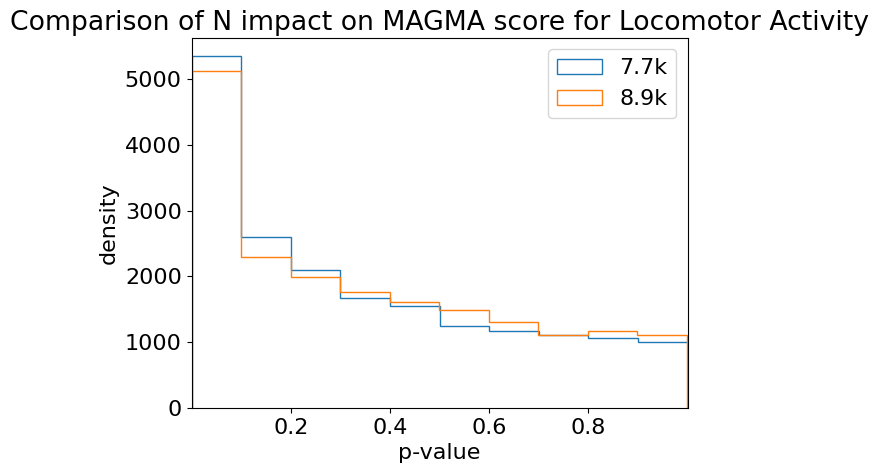

In [30]:
k='MAGMA'
plt.hist(magma_dict['loco'].P,histtype='step', stacked=True, fill=False,label='7.7k')
plt.hist(loco[10].P,histtype='step', stacked=True, fill=False,label='8.9k')

fig=plt.title('Comparison of N impact on MAGMA score for Locomotor Activity')
fig=plt.xlabel('p-value')
fig=plt.ylabel('density')
fig=plt.legend()
plt.margins(x=0)

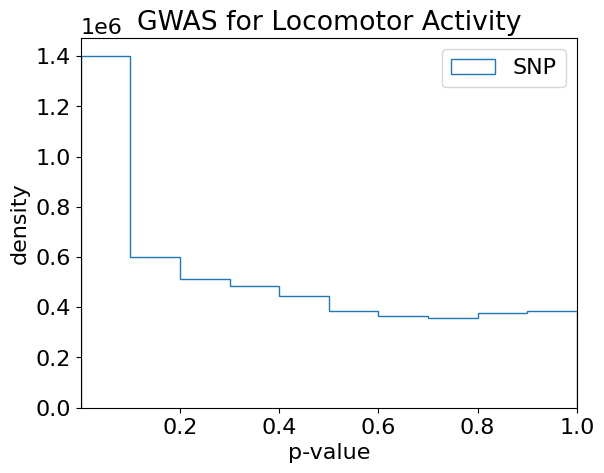

In [15]:
k='SNP'
plt.hist(snp_dict['loco'].p,histtype='step', stacked=True, fill=False,label=k)
fig=plt.title('GWAS for Locomotor Activity')
fig=plt.xlabel('p-value')
fig=plt.ylabel('density')
fig=plt.legend()
plt.margins(x=0)

### externalizing

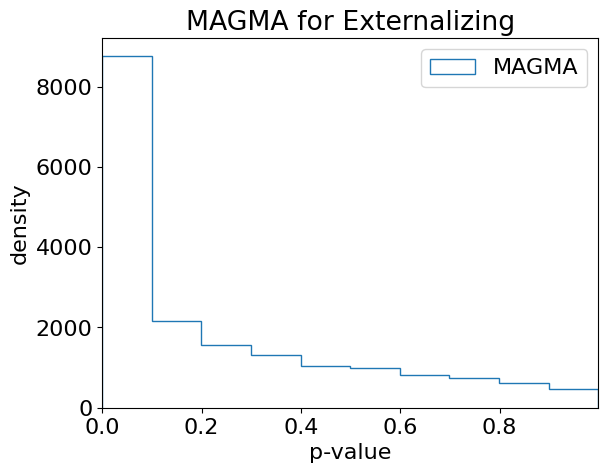

In [16]:
k='MAGMA'
plt.hist(magma_dict['ext'].P,histtype='step', stacked=True, fill=False,label=k)
fig=plt.title('MAGMA for Externalizing')
fig=plt.xlabel('p-value')
fig=plt.ylabel('density')
fig=plt.legend()
plt.margins(x=0)

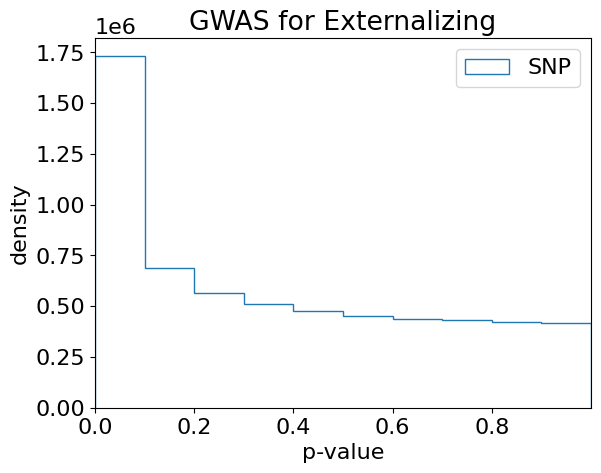

In [17]:
k='SNP'
plt.hist(snp_dict['ext'].P,histtype='step', stacked=True, fill=False,label=k)
fig=plt.title('GWAS for Externalizing')
fig=plt.xlabel('p-value')
fig=plt.ylabel('density')
fig=plt.legend()
plt.margins(x=0)

## histogram across phenotypes

KeyError: 'smkinit'

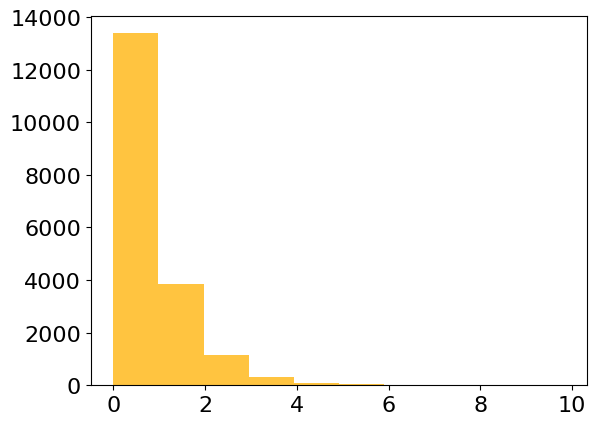

In [18]:
plt.hist(-np.log10(magma_dict['loco'].P), bins=None, histtype='stepfilled',density=False, rwidth=0.75,color=colour_dict['loco'], label='smkinit',alpha=0.75)
plt.hist(-np.log10(magma_dict['smkinit_pc1'].P), bins=None, histtype='stepfilled',density=False, rwidth=0.75,color=colour_dict['smkinit'], label='smkinit',alpha=0.75)
plt.hist(-np.log10(magma_dict['cigday_pc1'].P), bins=None,histtype='stepfilled',density=False, rwidth=0.75,color=colour_dict['cigday'], label='cigday',alpha=0.75)
plt.yscale('log')
fig=plt.xlabel('SNP -log10(p)')
fig=plt.ylabel('density')
plt.margins(x=0)

#plt.legend()

KeyError: 'smkinit'

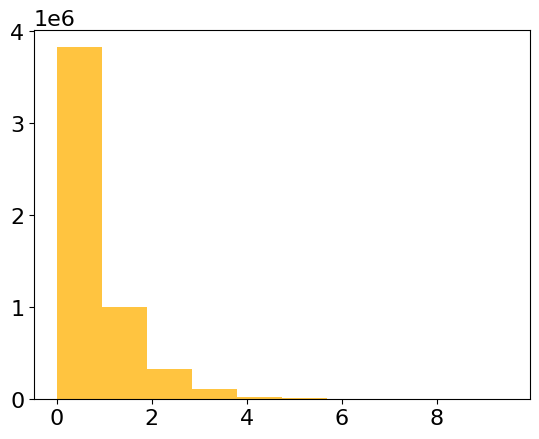

In [19]:
plt.hist(-np.log10(snp_dict['loco'].p), bins=None, histtype='stepfilled',density=False, rwidth=0.75,color=colour_dict['loco'], label='smkinit',alpha=0.75)
plt.hist(-np.log10(snp_dict['smkinit_pc1'].p), bins=None, histtype='stepfilled',density=False, rwidth=0.75,color=colour_dict['smkinit'], label='smkinit',alpha=0.75)
plt.hist(-np.log10(snp_dict['cigday_pc1'].p), bins=None,histtype='stepfilled',density=False, rwidth=0.75,color=colour_dict['cigday'], label='cigday',alpha=0.75)
plt.yscale('log')
fig=plt.xlabel('SNP -log10(p)')
fig=plt.ylabel('density')
plt.margins(x=0)

#plt.legend()

# manhattan and QQ plot

## locomotor activity

In [52]:
#plt.rcParams.update({'font.size': 12})

In [32]:
k='loco_final_cf'

#### SNP

In [45]:
rat_snp_strin=5.58
rat_snp_len=5.38

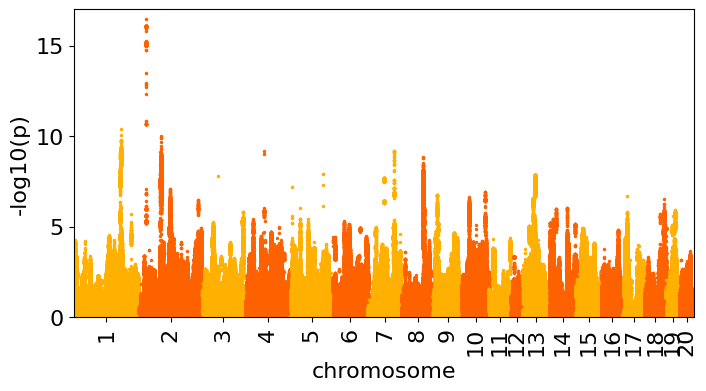

In [46]:
fig=plt.figure(figsize=(8,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=snp_dict[k].p,pos=snp_dict[k].bp,chr=snp_dict[k].Chr,label='',
                    cut=0,lines=[],lines_colors=['black','black'], colors=[colour_dict[k], colour_dict[(k+'_alt')]],
                    lines_widths = [1,1], lines_styles = ["--","--"], markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('-log10(p)')
plt.margins(x=0)
#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_fig:
    plt.savefig('figures/manhattan_cut'+'_'+k+'_SNP'+'.png',dpi=600,bbox_inches='tight')

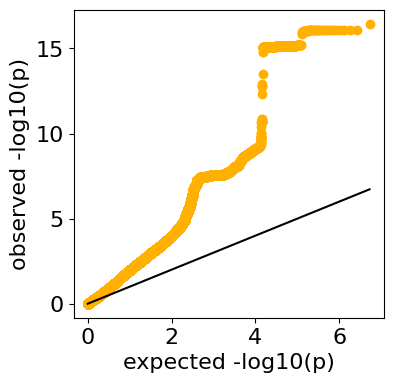

In [47]:
qqplot_gwas(snp_dict[k].p,colour_dict[k],save_fig,('qqplot_cut_'+k+'_SNP'))

#### magma

In [ ]:
# need to add one for top500

In [33]:
magma_len=-np.log10(max(magma_dict[k][magma_dict[k]['Q']<0.05]['P']))
magma_strin=-np.log10(0.05/len(magma_dict[k]))
magma_top500=-np.log10(max(magma_dict[k][(magma_dict[k]['HM_ORTHO'].isin(all_nodes))].nsmallest(500,'P')['P']))

In [34]:
cut=magma_top500

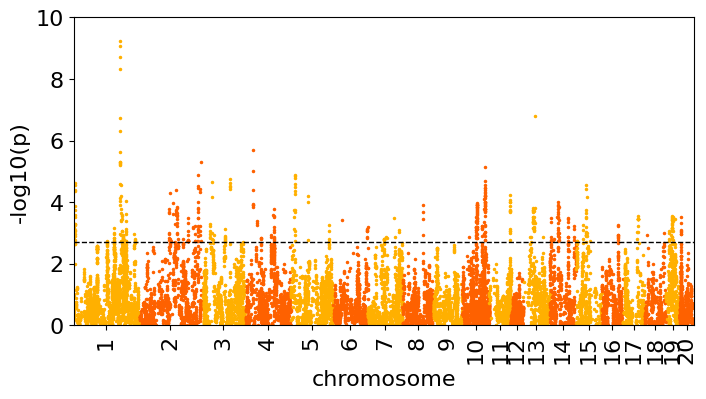

In [35]:
fig=plt.figure(figsize=(8,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=magma_dict[k]['P'],pos=magma_dict[k]['START'],chr=magma_dict[k]['CHR'],label='',
                    cut=0,lines=[cut],lines_colors=['black','black'], colors=[colour_dict[k], colour_dict[k+'_alt']],
                    lines_widths = [1,1], lines_styles = ["--","--"], markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('-log10(p)')
plt.margins(x=0)
#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_fig:
    plt.savefig('figures/manhattan_cut'+'_'+str(cut)+'_'+k+'_magma'+'.png',dpi=600,bbox_inches='tight')

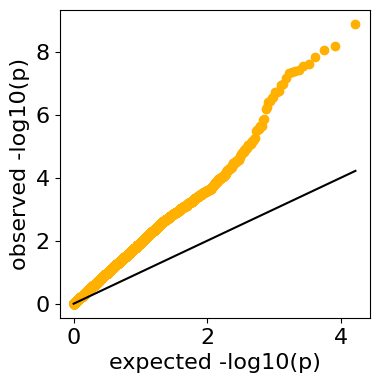

In [31]:
qqplot_gwas(magma_dict[k].P,colour_dict[k],save_fig,('qqplot_cut'+k+'_magma'))

## compare 7.7k vs 8.9k N for MAGMA run

In [26]:
magma_dict[k]

GENE  CHR     START      STOP  NSNPS  NPARAM     N     ZSTAT  \
0            Vom2r5    1   1151906   1180559      2       1  7722  1.639900   
1            Vom2r6    1   1204035   1232755      2       1  7722  1.853600   
2      LOC102547284    1   1735535   1764558      3       1  7722  0.322850   
3            Raet1c    1   1781462   1806110      2       1  7722 -0.002043   
4      LOC120093164    1   1797226   1822755      2       1  7722 -0.002043   
...             ...  ...       ...       ...    ...     ...   ...       ...   
18942         Ascc3   20  53500137  53805446    340       1  7722  0.449350   
18943          Sim1   20  53817601  53917219    148       1  7722  0.479350   
18944  LOC103694460   20  54404724  54428200     56       1  7722  0.434780   
18945          Cd99   20  54408239  54432882     53       1  7722  0.439540   
18946  LOC120098985   20  54413518  54436320     39       1  7722  0.442320   

              P         Q  
0      0.050510  0.264222  
1      0.031899  0.212814  
2      0.373400  0.659981  
3      0.500820  0.741569  
4      0.500820  0.741569  
...         ...       ...  
18942  0.326590  0.627184  
18943  0.315840  0.619741  
18944  0.331860  0.630794  
18945  0.330130  0.629526  
18946  0.329130  0.629222  

[18947 rows x 10 columns]

In [27]:
loco[10]

GENE  CHR     START      STOP  NSNPS  NPARAM     N     ZSTAT  \
0            Vom2r5    1   1151906   1180559      2       1  8679  1.639900   
1            Vom2r6    1   1204035   1232755      2       1  8679  1.853600   
2      LOC102547284    1   1735535   1764558      3       1  8679  0.322850   
3            Raet1c    1   1781462   1806110      2       1  8679 -0.002043   
4      LOC120093164    1   1797226   1822755      2       1  8679 -0.002043   
...             ...  ...       ...       ...    ...     ...   ...       ...   
18942         Ascc3   20  53500137  53805446    340       1  8679  0.449350   
18943          Sim1   20  53817601  53917219    148       1  8679  0.479350   
18944  LOC103694460   20  54404724  54428200     56       1  8679  0.434780   
18945          Cd99   20  54408239  54432882     53       1  8679  0.439540   
18946  LOC120098985   20  54413518  54436320     39       1  8679  0.442320   

              P  
0      0.050510  
1      0.031899  
2      0.373400  
3      0.500820  
4      0.500820  
...         ...  
18942  0.326590  
18943  0.315840  
18944  0.331860  
18945  0.330130  
18946  0.329130  

[18947 rows x 9 columns]

Text(0, 0.5, 'p-value 8.9k rats (N phenotyped)')

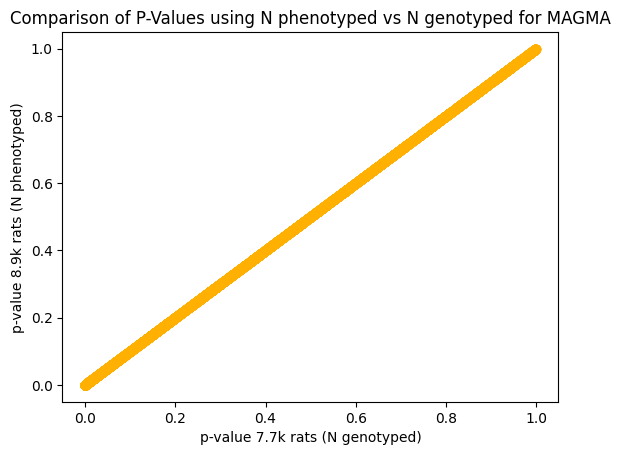

In [63]:
plt.scatter(x=magma_dict[k].P,y=loco[10].P, color=colour_dict[k])
plt.title('Comparison of P-Values using N phenotyped vs N genotyped for MAGMA')
plt.xlabel('p-value 7.7k rats (N genotyped)')
plt.ylabel('p-value 8.9k rats (N phenotyped)')

In [42]:
comp=magma_dict[k][['GENE','P','ZSTAT','Q']].merge(loco[10][['GENE','P','ZSTAT','Q']], on='GENE')

In [47]:
comp['pdiff']=np.absolute(comp.P_y-comp.P_x)
comp['zstat_diff']=np.absolute(comp.ZSTAT_y-comp.ZSTAT_x)

In [59]:
comp[comp['pdiff']>0].sort_values('pdiff', ascending=False)

GENE           P_x  ZSTAT_x       Q_x           P_y  ZSTAT_y  \
3476      Dennd4b  9.710000e-01  -1.8957  0.982036  9.711800e-01  -1.8984   
4101        Fubp3  9.621700e-01  -1.7764  0.978433  9.621400e-01  -1.7761   
15885      Mrps16  4.592200e-04   3.3144  0.039470  4.366700e-04   3.3284   
811    RGD1561430  9.816700e-01  -2.0896  0.988925  9.816500e-01  -2.0892   
12464      Kctd11  9.902400e-01  -2.3353  0.993438  9.902200e-01  -2.3348   
...           ...           ...      ...       ...           ...      ...   
3843       Mcoln3  6.556300e-06   4.3582  0.006901  6.556400e-06   4.3582   
1849        Cuzd1  6.120100e-07   4.8517  0.001657  6.120200e-07   4.8517   
1861        Cpxm2  5.105600e-09   5.7272  0.000024  5.105100e-09   5.7272   
1859         Bub3  5.117700e-10   6.1057  0.000010  5.116400e-10   6.1057   
1857         Hmx3  4.045500e-09   5.7666  0.000024  4.045400e-09   5.7666   

            Q_y         pdiff  zstat_diff  
3476   0.982117  1.800000e-04      0.0027  
4101   0.978406  3.000000e-05      0.0003  
15885  0.039026  2.255000e-05      0.0140  
811    0.988905  2.000000e-05      0.0004  
12464  0.993418  2.000000e-05      0.0005  
...         ...           ...         ...  
3843   0.006901  1.000000e-10      0.0000  
1849   0.001657  1.000000e-11      0.0000  
1861   0.000024  5.000000e-13      0.0000  
1859   0.000010  1.300000e-13      0.0000  
1857   0.000024  1.000000e-13      0.0000  

[712 rows x 9 columns]

In [60]:
comp[comp['zstat_diff']>0].sort_values('zstat_diff', ascending=False)

GENE       P_x   ZSTAT_x       Q_x       P_y   ZSTAT_y       Q_y  \
15885      Mrps16  0.000459  3.314400  0.039470  0.000437  3.328400  0.039026   
3476      Dennd4b  0.971000 -1.895700  0.982036  0.971180 -1.898400  0.982117   
13705     B4galt4  0.995090 -2.582200  0.996194  0.995100 -2.583100  0.996204   
12039      Gabra6  0.000026  4.048000  0.015104  0.000026  4.047400  0.015104   
6302        Hdhd5  0.992270 -2.421600  0.994474  0.992290 -2.422200  0.994495   
...           ...       ...       ...       ...       ...       ...       ...   
4100         Ass1  0.498350  0.004138  0.740904  0.498350  0.004138  0.740904   
16750     Ppp1r3b  0.499840  0.000412  0.740995  0.499840  0.000412  0.740995   
15608  C14h4orf50  0.500290 -0.000729  0.741301  0.500290 -0.000729  0.741301   
4766       Tmco5b  0.499830  0.000415  0.740995  0.499830  0.000415  0.740995   
2610        Nolc1  0.499750  0.000615  0.740995  0.499750  0.000615  0.740995   

              pdiff    zstat_diff  
15885  2.255000e-05  1.400000e-02  
3476   1.800000e-04  2.700000e-03  
13705  1.000000e-05  9.000000e-04  
12039  5.900000e-08  6.000000e-04  
6302   2.000000e-05  6.000000e-04  
...             ...           ...  
4100   0.000000e+00  1.000000e-07  
16750  0.000000e+00  9.000000e-08  
15608  0.000000e+00  5.000000e-08  
4766   0.000000e+00  3.000000e-08  
2610   0.000000e+00  1.000000e-08  

[1103 rows x 9 columns]

### check if seed genes are the same

In [56]:
#bonferroni
set(comp[comp.P_x<0.05/len(comp)]['GENE'])==set(comp[comp.P_y<0.05/len(comp)]['GENE'])

True

In [57]:
#FDR<0.05
set(comp[comp.Q_x<0.05]['GENE'])==set(comp[comp.Q_x<0.05]['GENE'])

True

they are! thank fucking god- this means all of the downstream network analysis doesn't need to be redone

## addiction risk factor

In [17]:
k='addict-rf'
j='ext'

#### SNP

In [31]:
snp_dict[k]=snp_dict[k].dropna()
snp_dict[k]['Chr']=snp_dict[k].Chr.astype(int)
snp_dict[k]['BP']=snp_dict[k].BP.astype(int)
snp_dict[k]=snp_dict[k].reset_index()

In [18]:
cutoff=-np.log10(5e-8)

In [32]:
snp_dict[k]

index         SNP  Chr         BP A1 A2      Beta         P
0              0   rs1000000   12  126890980  G  A  0.001000  0.701658
1              1  rs10000003    4   57561647  A  G -0.000128  0.956505
2              2  rs10000011    4  138223055  C  T  0.002092  0.693489
3              3  rs10000013    4   37225069  C  A -0.004691  0.082888
4              4  rs10000015    4   84143987  A  G  0.001398  0.766094
...          ...         ...  ...        ... .. ..       ...       ...
3511903  3511958   rs9999983    4  151115333  C  T -0.001235  0.760886
3511904  3511959   rs9999985    4   38779091  A  G -0.017284  0.007905
3511905  3511960   rs9999995    4  185171608  A  G -0.006506  0.104501
3511906  3511961   rs9999996    4   69782467  C  A  0.008015  0.010269
3511907  3511962   rs9999998    4  117161848  C  T -0.003295  0.269001

[3511908 rows x 8 columns]

In [89]:
save_fig=True

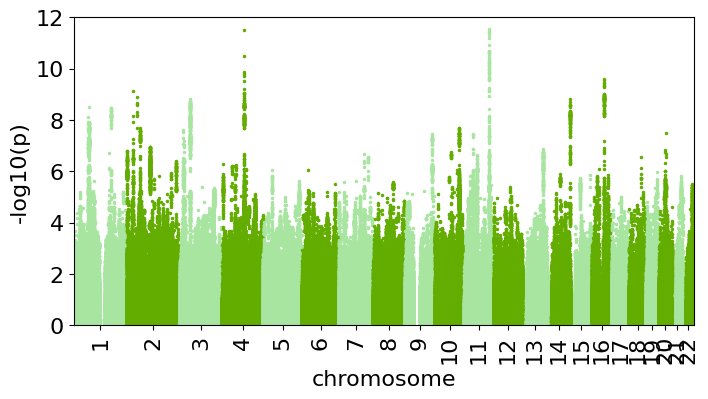

In [90]:
fig=plt.figure(figsize=(8,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=snp_dict[k].P,pos=snp_dict[k].BP,chr=snp_dict[k].Chr,label='',
                    cut=0,lines=[],lines_colors=['black'], colors=[colour_dict[k], colour_dict[(k+'_alt')]],
                    lines_widths = [1], lines_styles = ["--"], markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('-log10(p)')
plt.margins(x=0)
#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_fig:
    plt.savefig('figures/manhattan_cut'+str(cutoff)+'_'+k+'_SNP'+'.png',dpi=600,bbox_inches='tight')

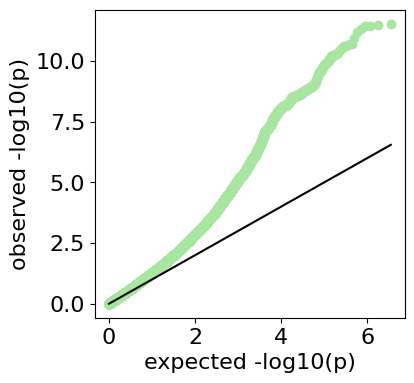

In [91]:
qqplot_gwas(snp_dict[k].P,colour_dict[k],save_fig,('qqplot_cut'+str(cutoff)+'_'+k+'_SNP'))

#### magma

In [92]:
magma_len=-np.log10(max(magma_dict[k][magma_dict[k]['Q']<0.05]['P']))
magma_strin=-np.log10(0.05/len(magma_dict[k]))
magma_top500=-np.log10(max(magma_dict[k][(magma_dict[k]['GENE'].isin(all_nodes))].nsmallest(500,'P')['P']))

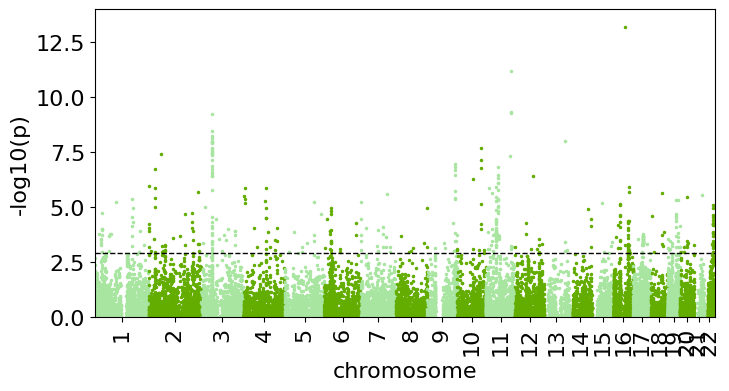

In [93]:
fig=plt.figure(figsize=(8,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=magma_dict[k]['P'],pos=magma_dict[k]['START'],chr=magma_dict[k]['CHR'],label='',
                    cut=0,lines=[magma_len],lines_colors=['black','black'], colors=[colour_dict[k], colour_dict[k+'_alt']],
                    lines_widths = [1,1], lines_styles = ["--","--"], markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('-log10(p)')
plt.margins(x=0)
#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_fig:
    plt.savefig('figures/manhattan_cut'+str(cutoff)+'_'+k+'_magma'+'.png',dpi=600,bbox_inches='tight')

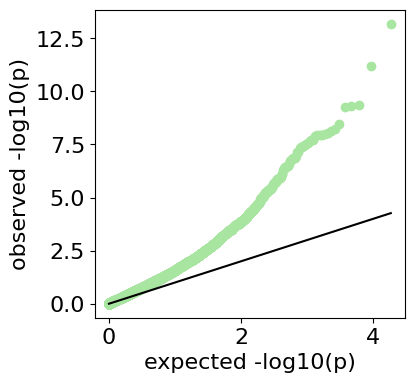

In [94]:
qqplot_gwas(magma_dict[k].P,colour_dict[k],save_fig,('qqplot_cut'+str(cutoff)+'_'+k+'_magma'))

## externalizing (2019)

In [35]:
k='ext'

#### SNP

In [36]:
cutoff=-np.log10(5e-8)

In [67]:
cutoff

7.301029995663981

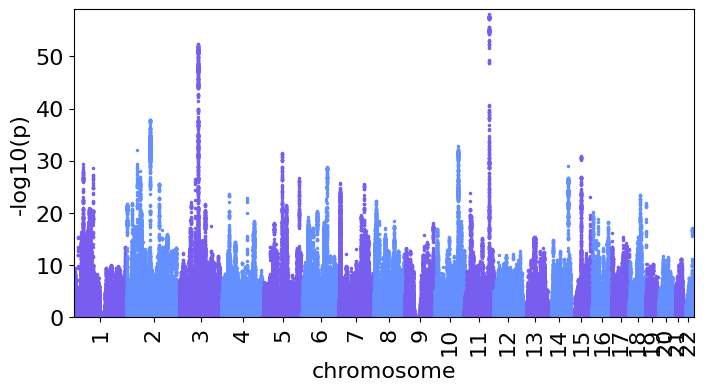

In [37]:
fig=plt.figure(figsize=(8,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=snp_dict[k].P,pos=snp_dict[k].BP,chr=snp_dict[k].CHR,label='',
                    cut=0,lines=[],lines_colors=['black'], colors=[colour_dict[k], colour_dict[(k+'_alt')]],
                    lines_widths = [1], lines_styles = ["--"], markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('-log10(p)')
plt.margins(x=0)
#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_fig:
    plt.savefig('figures/manhattan_cut'+str(cutoff)+'_'+k+'_SNP'+'.png',dpi=600,bbox_inches='tight')

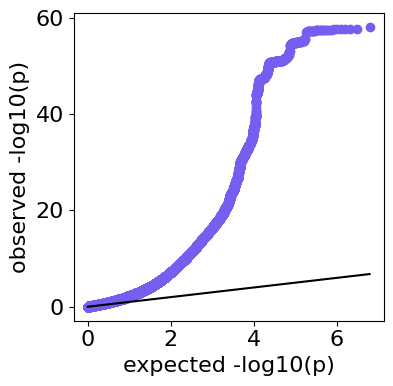

In [38]:
qqplot_gwas(snp_dict[k].P,colour_dict[k],save_fig,('qqplot_cut'+str(cutoff)+'_'+k+'_SNP'))

#### magma

In [68]:
magma_len=-np.log10(max(magma_dict[k][magma_dict[k]['Q']<0.05]['P']))
magma_strin=-np.log10(0.05/len(magma_dict[k]))
magma_top500=-np.log10(max(magma_dict[k][(magma_dict[k]['GENE'].isin(all_nodes))].nsmallest(500,'P')['P']))

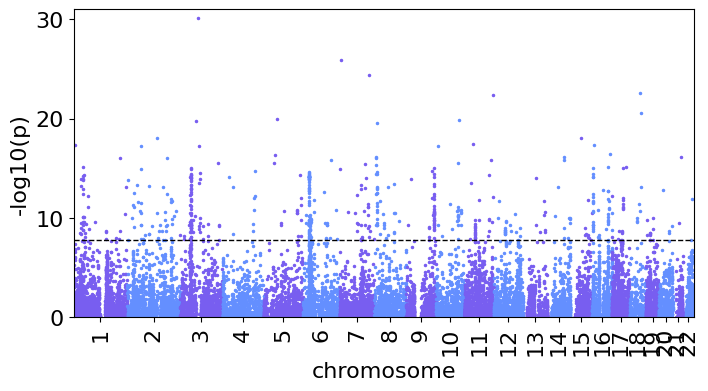

In [69]:
fig=plt.figure(figsize=(8,4))
#fig, ax=plt.subplots(figsize=(10,4))
manhattan(pval=magma_dict[k]['P'],pos=magma_dict[k]['START'],chr=magma_dict[k]['CHR'],label='',
                    cut=0,lines=[magma_top500],lines_colors=['black','black'], colors=[colour_dict[k], colour_dict[k+'_alt']],
                    lines_widths = [1,1], lines_styles = ["--","--"], markersize=3, plot_grid_lines=False)
fig=plt.title('')
fig=plt.ylabel('-log10(p)')
plt.margins(x=0)
#commented out- use to turn into miami plot
#plt.gca().invert_yaxis()
#plt.tick_params(axis='x',labeltop=True, top=True, bottom=False, labelbottom=False)
fig=plt.xticks(rotation='vertical')
if save_fig:
    plt.savefig('figures/manhattan_cut'+str(cutoff)+'_'+k+'_magma'+'.png',dpi=600,bbox_inches='tight')

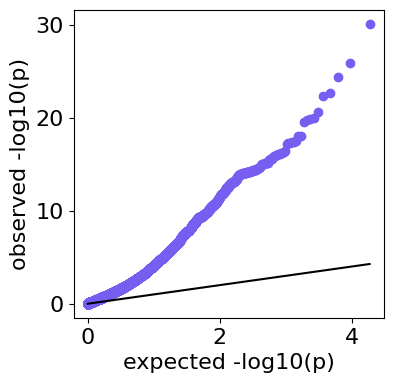

In [70]:
qqplot_gwas(magma_dict[k].P,colour_dict[k],save_fig,('qqplot_cut'+str(cutoff)+'_'+k+'_magma'))

# venn diagram of externalizing, locomotor activity, and addiction risk factor

In [76]:
seed_dict=import_seed_dict(mag_dir,file_dict,bonf_dict,gene_col_dict,all_nodes)
seed_dict.keys()
#dictionary of human control traits
ctrl_dict={}
ctrl_traits=['facial_hair', 'age_smkinit', 'antisoc', 'friend_sat', 'hr', 'infant_bw', 'LDL', 'maternal_smok', 'townsend', 'age_menarche', 'neurot','addict-rf']
for t in ctrl_traits:
    ctrl_dict[t]=pd.read_csv('gwas_ctrl_hm/magma/seed_genes/'+t+'_annot.tsv',sep='\t')
for t in ctrl_traits:
    seed_dict[t+'_FDR']=(set(ctrl_dict[t][ctrl_dict[t]['Q']<0.05]['GENE']))
    seed_dict[t+'_bonf']=(set(ctrl_dict[t][ctrl_dict[t]['P']<0.05/len(ctrl_dict[t])]['GENE']))
    seed_dict[t+'_top500']=set(ctrl_dict[t][(ctrl_dict[t]['GENE'].isin(all_nodes))].nsmallest(500,'P')['GENE'])

In [144]:
ext=seed_dict['ext_top500']

In [145]:
loco=seed_dict['loco_gsem_FDR']

In [146]:
adrf=seed_dict['addict-rf_FDR']

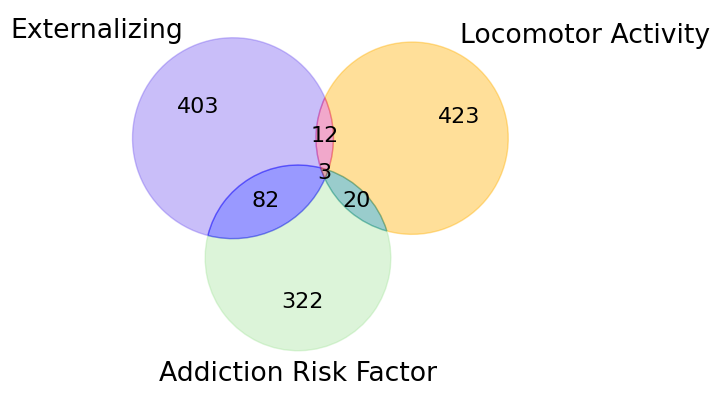

In [147]:
# Correct labeling with explicit set operations for Venn diagram
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Define the three sets of genes
set1 = ext
set2 =loco
set3 =adrf

# Create the Venn diagram
venn = venn3([set1, set2, set3], ('Externalizing', 'Locomotor Activity', 'Addiction Risk Factor'))

# Customize colors for each section
colors = {
    '100': colour_dict['ext'], '010': colour_dict['loco'], '001': colour_dict['addict-rf'],
    '110': colour_dict['shared'], '101': 'blue', '011': 'teal', '111': 'brown'
}
for id_, color in colors.items():
    patch = venn.get_patch_by_id(id_)
    if patch:
        patch.set_color(color)


plt.show()


In [148]:
magma_dict['ext'][magma_dict['ext']['GENE'].isin(ext.intersection(loco))]

ID      GENE  CHR      START       STOP  NSNPS  NPARAM        N  \
2315     4190      MDH1    2   63578609   63617197     90       6  1492085   
2316     7360      UGP2    2   63830950   63901562    133       9  1492085   
2317    51542     VPS54    2   63882150   64029080    349      20  1492085   
3980   131034     CPNE4    3  131523560  132295547   2542      80  1492085   
4887    57484    RNF150    4  140849807  141222869    444      41  1492085   
6630     5454    POU3F2    6   98824704   98848790     10       3  1492085   
7637   168850    ZNF800    7  127336721  127402724     77      10  1492085   
7638    79571      GCC1    7  127570628  127595600     27       8  1492085   
7639      381      ARF5    7  127578352  127601705     26       6  1492085   
7640    29999     FSCN3    7  127583635  127611797     31       7  1492085   
7641     5078      PAX4    7  127600292  127628192     29       9  1492085   
8003     2185     PTK2B    8   27301482   27469391    462      41  1492085   
8004     1135    CHRNA2    8   27449761   27489296     82      12  1492085   
10397   91252  SLC39A13   11   47397132   47426500     58       7  1492085   
10398    5702     PSMC3   11   47408769   47436473     60       6  1492085   

        ZSTAT             P             Q  
2315   6.1094  5.000000e-10  2.406984e-08  
2316   6.1094  5.000000e-10  2.406984e-08  
2317   6.5386  3.105300e-11  2.346846e-09  
3980   6.1357  4.239100e-10  2.255494e-08  
4887   5.8983  1.836500e-09  7.728326e-08  
6630   7.2366  2.299800e-13  3.108255e-11  
7637   5.9773  1.134000e-09  5.011252e-08  
7638   6.8483  3.736500e-12  3.699734e-10  
7639   6.7357  8.158000e-12  7.515101e-10  
7640   6.4543  5.435000e-11  3.855726e-09  
7641   6.7276  8.624700e-12  7.892103e-10  
8003   5.7621  4.154200e-09  1.576212e-07  
8004   6.9569  1.739100e-12  1.861340e-10  
10397  5.6034  1.050800e-08  3.664146e-07  
10398  5.5884  1.146000e-08  3.951459e-07

In [105]:
ortho=pd.read_csv('/tscc/projects/ps-palmer/brittany/orthology_ref_tbls/ORTHOLOGY-ALLIANCE_COMBINED_2024.tsv',sep='\t',skiprows=15)
#downloaded from https://www.alliancegenome.org/downloads#orthology on 11 June 2024
#filter for rat-human
ortho=ortho[(ortho['Gene1SpeciesName']=='Rattus norvegicus')&(ortho['Gene2SpeciesName']=='Homo sapiens')]
#filter for best match
ortho=ortho[ortho['IsBestScore']=='Yes']

In [149]:
loco_tbl=magma_dict['loco'].merge(ortho[['Gene1Symbol','Gene2Symbol']], left_on='GENE',right_on='Gene1Symbol')

In [150]:
loco.intersection(list(ext)+list(adrf))

{'ACTG2',
 'AGBL2',
 'ARF5',
 'ASB16',
 'ATXN7L3',
 'CELF1',
 'CHRNA2',
 'CISD2',
 'CPNE4',
 'CSTF3',
 'EYA1',
 'FSCN3',
 'GCC1',
 'GRN',
 'HIPK3',
 'LSM12',
 'MANBA',
 'MDH1',
 'NAGS',
 'PAX4',
 'POU3F2',
 'PSMC3',
 'PTK2B',
 'RAPSN',
 'RNF150',
 'SLC39A13',
 'SLC9B1',
 'SPI1',
 'STAMBP',
 'TMEM101',
 'TMUB2',
 'UBTF',
 'UGP2',
 'VPS54',
 'ZNF800'}

In [151]:
loco_tbl=loco_tbl[loco_tbl.Gene2Symbol.isin(loco.intersection(list(ext)+list(adrf)))]

In [152]:
loco_tbl['ext'] = loco_tbl.Gene2Symbol.isin(ext)
loco_tbl['adrf'] = loco_tbl.Gene2Symbol.isin(adrf)

In [153]:
loco_tbl.merge(magma_dict['ext'][['GENE','CHR','START','STOP']],left_on='Gene2Symbol',right_on='GENE')

GENE_x  CHR_x    START_x     STOP_x  NSNPS  NPARAM     N   ZSTAT  \
0     Slc9b1      2  223759105  223828359     62       1  7722  3.5150   
1      Cisd2      2  223818937  223863768     61       1  7722  3.5924   
2      Manba      2  223900432  224012988    245       6  7722  3.7404   
3      Agbl2      3   76754893   76810071      2       1  7722  3.2945   
4      Celf1      3   76914591   77009429      2       1  7722  3.2860   
5      Rapsn      3   77005073   77034378     22       1  7722  3.1591   
6      Psmc3      3   77021825   77047207     18       1  7722  3.1467   
7   Slc39a13      3   77029411   77057528     30       1  7722  3.0832   
8       Spi1      3   77049744   77103730     36       1  7722  3.0308   
9      Hipk3      3   90786980   90876701    149       1  7722  3.0404   
10     Cstf3      3   90956415   91047669     91       1  7722  3.1038   
11    Zfp800      4   56788326   56859766     52       1  7722  3.4314   
12      Gcc1      4   57020817   57052682     78       1  7722  3.5060   
13      Arf5      4   57028521   57051447     67       1  7722  3.5163   
14     Fscn3      4   57032797   57062224     55       1  7722  3.4982   
15      Pax4      4   57048453   57075995     23       1  7722  3.5156   
16     Actg2      4  116011832  116056475    180       9  7722  3.5185   
17    Stambp      4  116045563  116093563     90       6  7722  2.9933   
18      Eya1      5    4853501    5111483    560      20  7722  3.8076   
19    Pou3f2      5   36067930   36093838     30       1  7722  3.7304   
20     Cpne4      8  105167376  105663075   2124      21  7722  3.2206   
21      Nags     10   87088330   87112465     47       3  7722  3.9514   
22   Tmem101     10   87095115   87118868     49       3  7722  3.9761   
23     Lsm12     10   87108334   87150395     48       3  7722  4.1821   
24     Asb16     10   87215976   87243078     51       5  7722  3.5994   
25     Tmub2     10   87228543   87252968     39       5  7722  3.2805   
26   Atxn7l3     10   87232843   87260186     50       5  7722  3.8455   
27      Ubtf     10   87248217   87284291     86       6  7722  4.0405   
28       Grn     10   87377672   87403777     28       5  7722  3.4125   
29     Vps54     14   95368821   95465871    202       1  7722  3.0320   
30      Ugp2     14   95446330   95507483     88       1  7722  2.9905   
31      Mdh1     14   95620625   95655920     95       1  7722  3.0185   
32    Chrna2     15   40332317   40368601     83       5  7722  3.3640   
33     Ptk2b     15   40350722   40491235    297       8  7722  3.3735   
34    Rnf150     19   24996978   25239273    741      20  7722  3.3269   

           P         Q Gene1Symbol Gene2Symbol    ext   adrf    GENE_y  CHR_y  \
0   0.000220  0.018873      Slc9b1      SLC9B1  False   True    SLC9B1      4   
1   0.000164  0.016187       Cisd2       CISD2  False   True     CISD2      4   
2   0.000092  0.012208       Manba       MANBA  False   True     MANBA      4   
3   0.000493  0.028187       Agbl2       AGBL2  False   True     AGBL2     11   
4   0.000508  0.028446       Celf1       CELF1  False   True     CELF1     11   
5   0.000791  0.035549       Rapsn       RAPSN  False   True     RAPSN     11   
6   0.000826  0.036534       Psmc3       PSMC3   True   True     PSMC3     11   
7   0.001024  0.041274    Slc39a13    SLC39A13   True   True  SLC39A13     11   
8   0.001220  0.045568        Spi1        SPI1  False   True      SPI1     11   
9   0.001181  0.045204       Hipk3       HIPK3  False   True     HIPK3     11   
10  0.000955  0.039432       Cstf3       CSTF3  False   True     CSTF3     11   
11  0.000300  0.022335      Zfp800      ZNF800   True  False    ZNF800      7   
12  0.000227  0.018991        Gcc1        GCC1   True  False      GCC1      7   
13  0.000219  0.018873        Arf5        ARF5   True  False      ARF5      7   
14  0.000234  0.019381       Fscn3       FSCN3   True  False     FSCN3      7   
15  0.000219  0.018873        Pax4        PAX

# run correlation for MAGMA- compare window size

## generate heat map of correlation

### fillna

/tmp/ipykernel_2360972/3550195562.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'P_x'} in the result is deprecated and will raise a MergeError in a future version.
  t=loco[0][['GENE','P']].merge(
/tmp/ipykernel_2360972/3550195562.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'P_x'} in the result is deprecated and will raise a MergeError in a future version.
  t=loco[0][['GENE','P']].merge(
/tmp/ipykernel_2360972/3550195562.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'P_x'} in the result is deprecated and will raise a MergeError in a future version.
  t=loco[0][['GENE','P']].merge(


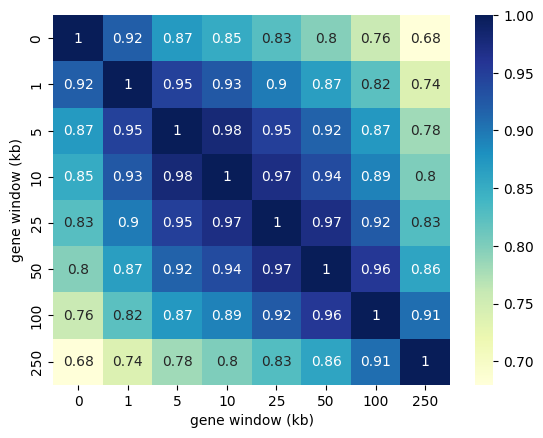

In [103]:
t=loco[0][['GENE','P']].merge(
    loco[1][['GENE','P']],on='GENE',how='outer').merge(
    loco[5][['GENE','P']],on='GENE',how='outer').merge(
    loco[10][['GENE','P']],on='GENE',how='outer').merge(
    loco[25][['GENE','P']],on='GENE',how='outer').merge(
    loco[50][['GENE','P']],on='GENE',how='outer').merge(
    loco[100][['GENE','P']],on='GENE',how='outer').merge(
    loco[250][['GENE','P']],on='GENE',how='outer').fillna(1)
t.columns=['GENE']+list(loco.keys())
matrix = t.corr(numeric_only=True)
dataplot = sb.heatmap(matrix, cmap="YlGnBu", annot=True) 
dataplot=plt.xlabel('gene window (kb)')
dataplot=plt.ylabel('gene window (kb)')
plt.savefig("figures/loco_magma_window_corr_pval_fillna.svg")

In [106]:
matrix['sum']=matrix.sum(axis=1)
matrix

0         1         5        10        25        50       100  \
0    1.000000  0.990996  0.981054  0.974536  0.960764  0.944939  0.920930   
1    0.990996  1.000000  0.990386  0.983638  0.970080  0.954448  0.930333   
5    0.981054  0.990386  1.000000  0.995327  0.982361  0.966747  0.942689   
10   0.974536  0.983638  0.995327  1.000000  0.989640  0.974398  0.950236   
25   0.960764  0.970080  0.982361  0.989640  1.000000  0.988937  0.965107   
50   0.944939  0.954448  0.966747  0.974398  0.988937  1.000000  0.982764   
100  0.920930  0.930333  0.942689  0.950236  0.965107  0.982764  1.000000   
250  0.870579  0.879939  0.891875  0.899226  0.913515  0.932048  0.959731   

          250        sum  
0    0.870579  15.287596  
1    0.879939  15.399638  
5    0.891875  15.500877  
10   0.899226  15.534004  
25   0.913515  15.540808  
50   0.932048  15.488563  
100  0.959731  15.303580  
250  1.000000  14.693824

### dropna

/tmp/ipykernel_2360972/3395289997.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'P_x'} in the result is deprecated and will raise a MergeError in a future version.
  t=loco[0][['GENE','P']].merge(
/tmp/ipykernel_2360972/3395289997.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'P_x'} in the result is deprecated and will raise a MergeError in a future version.
  t=loco[0][['GENE','P']].merge(
/tmp/ipykernel_2360972/3395289997.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'P_x'} in the result is deprecated and will raise a MergeError in a future version.
  t=loco[0][['GENE','P']].merge(
/tmp/ipykernel_2360972/3395289997.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  t=loco[0][['GENE','P']].merge(


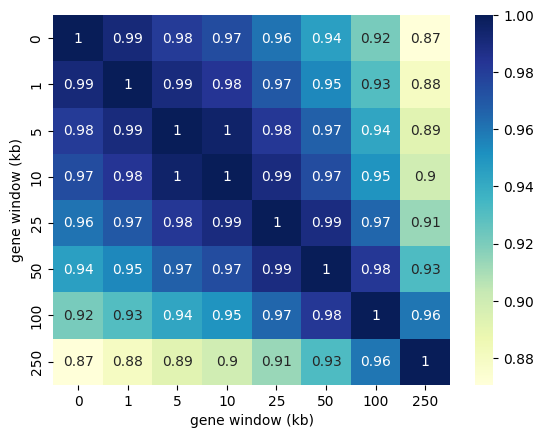

In [104]:
t=loco[0][['GENE','P']].merge(
    loco[1][['GENE','P']],on='GENE',how='outer').merge(
    loco[5][['GENE','P']],on='GENE',how='outer').merge(
    loco[10][['GENE','P']],on='GENE',how='outer').merge(
    loco[25][['GENE','P']],on='GENE',how='outer').merge(
    loco[50][['GENE','P']],on='GENE',how='outer').merge(
    loco[100][['GENE','P']],on='GENE',how='outer').merge(
    loco[250][['GENE','P']],on='GENE',how='outer').dropna(0)
t.columns=['GENE']+list(loco.keys())
matrix = t.corr(numeric_only=True)
dataplot = sb.heatmap(matrix, cmap="YlGnBu", annot=True)
dataplot=plt.xlabel('gene window (kb)')
dataplot=plt.ylabel('gene window (kb)')
plt.savefig("figures/loco_magma_window_corr_pval_dropna.svg")

In [105]:
matrix['sum']=matrix.sum(axis=1)
matrix

0         1         5        10        25        50       100  \
0    1.000000  0.990996  0.981054  0.974536  0.960764  0.944939  0.920930   
1    0.990996  1.000000  0.990386  0.983638  0.970080  0.954448  0.930333   
5    0.981054  0.990386  1.000000  0.995327  0.982361  0.966747  0.942689   
10   0.974536  0.983638  0.995327  1.000000  0.989640  0.974398  0.950236   
25   0.960764  0.970080  0.982361  0.989640  1.000000  0.988937  0.965107   
50   0.944939  0.954448  0.966747  0.974398  0.988937  1.000000  0.982764   
100  0.920930  0.930333  0.942689  0.950236  0.965107  0.982764  1.000000   
250  0.870579  0.879939  0.891875  0.899226  0.913515  0.932048  0.959731   

          250       sum  
0    0.870579  7.643798  
1    0.879939  7.699819  
5    0.891875  7.750439  
10   0.899226  7.767002  
25   0.913515  7.770404  
50   0.932048  7.744282  
100  0.959731  7.651790  
250  1.000000  7.346912

## plot correlation plots

### PVal- fillna

/tmp/ipykernel_962736/2992066994.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(4,4))


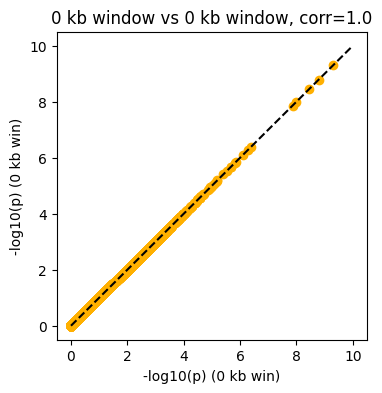

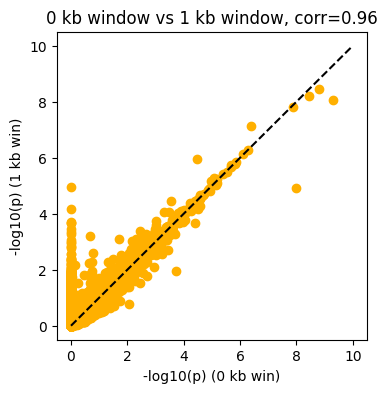

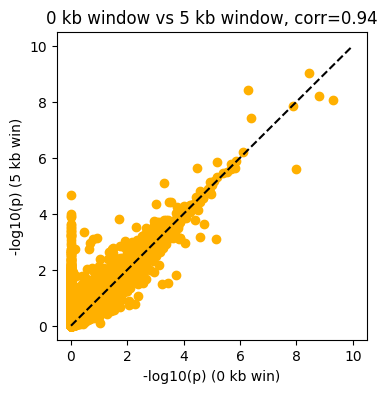

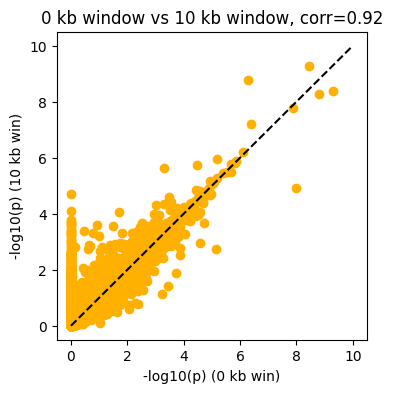

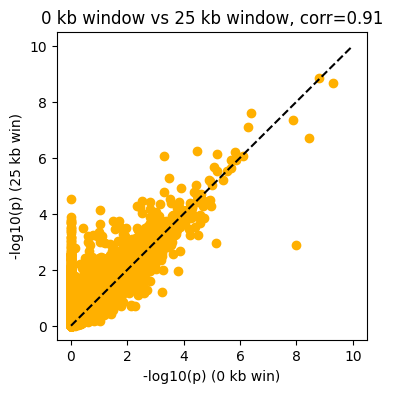

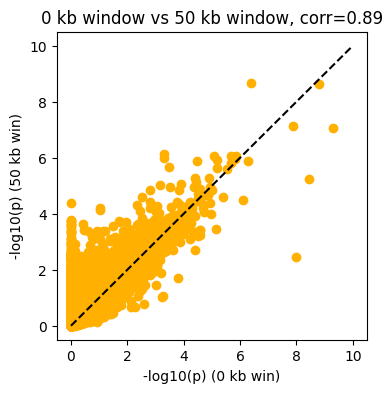

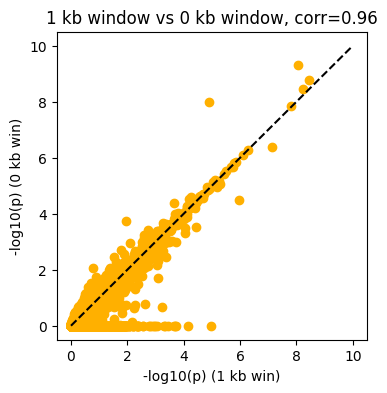

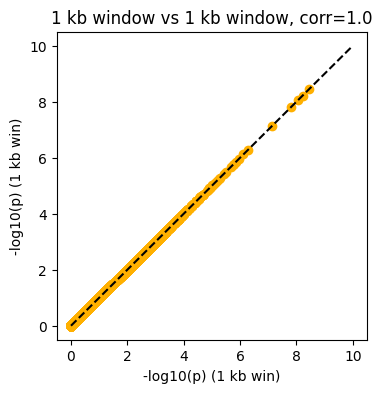

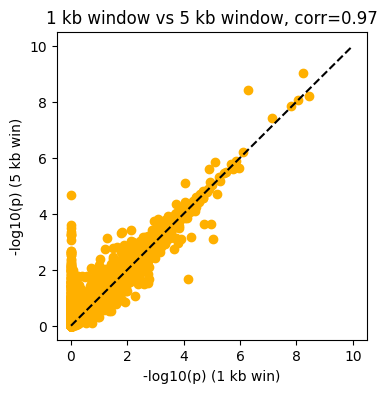

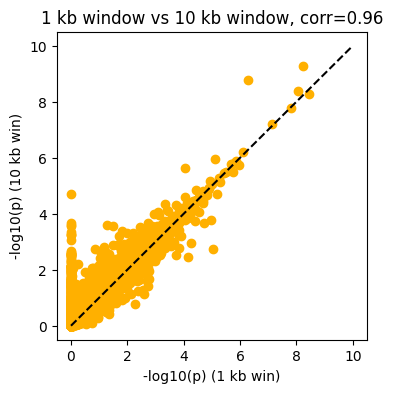

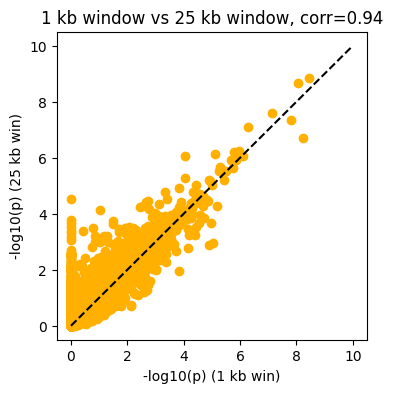

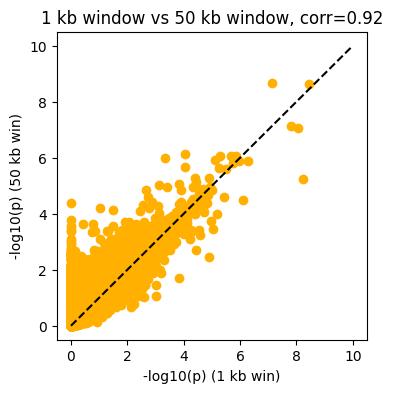

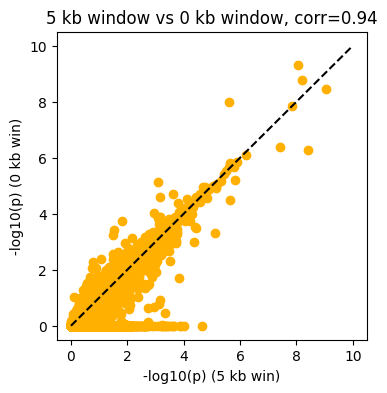

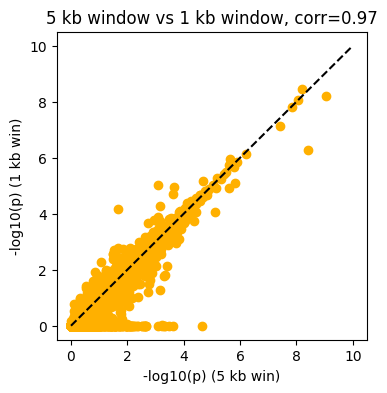

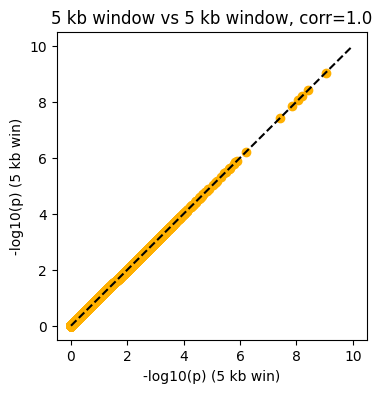

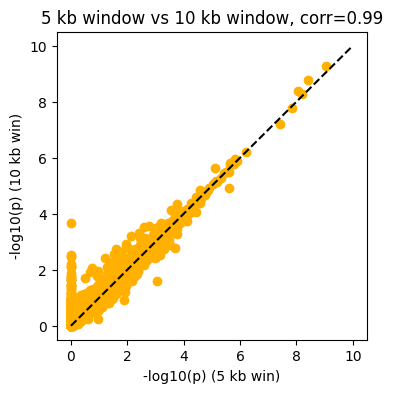

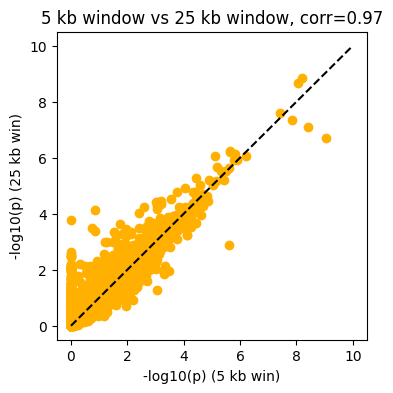

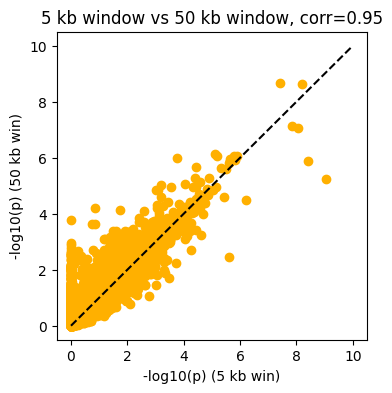

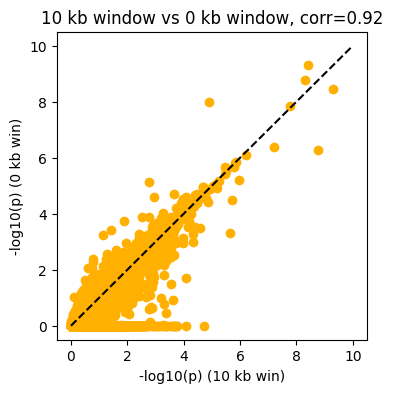

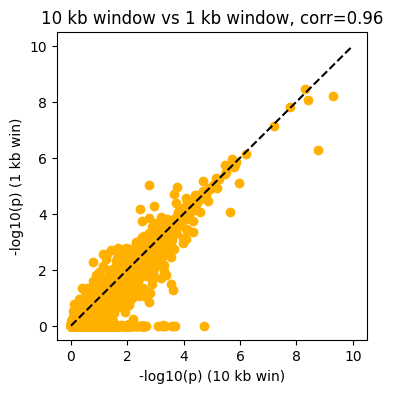

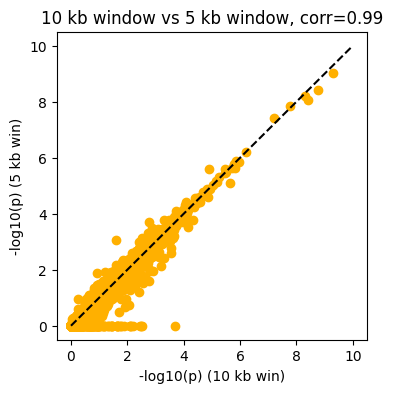

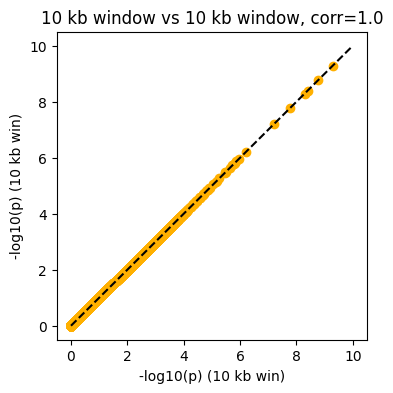

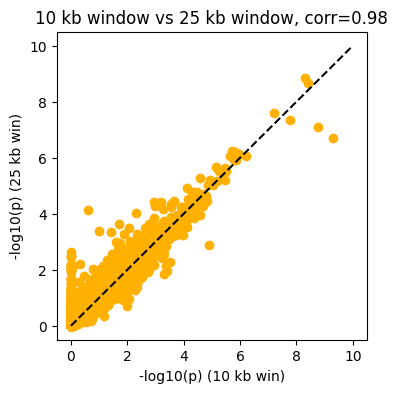

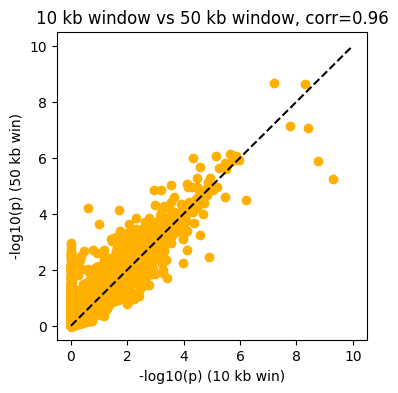

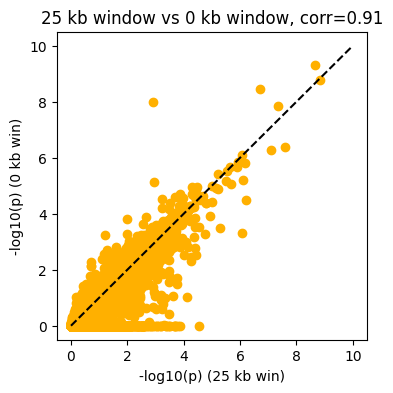

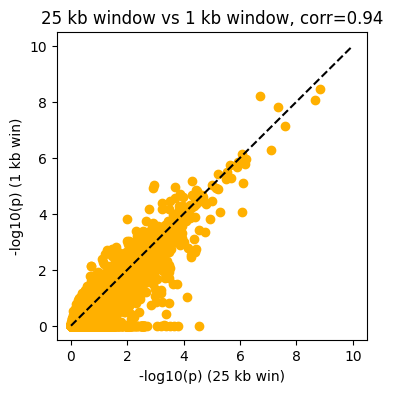

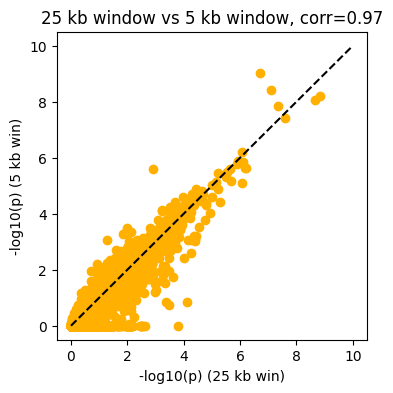

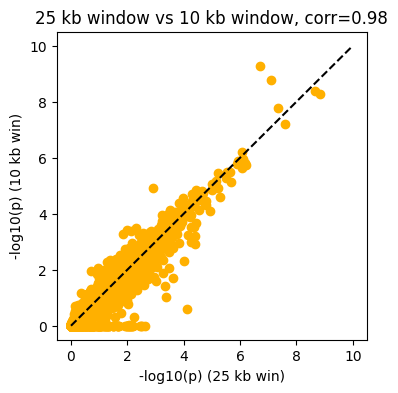

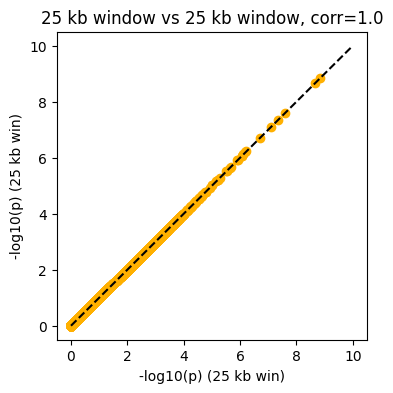

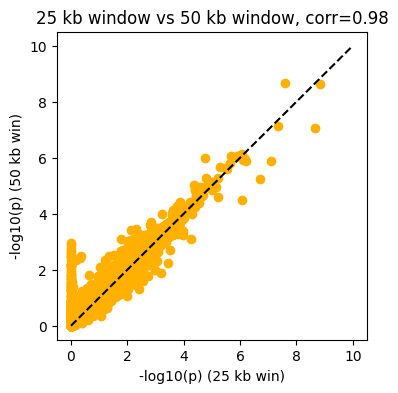

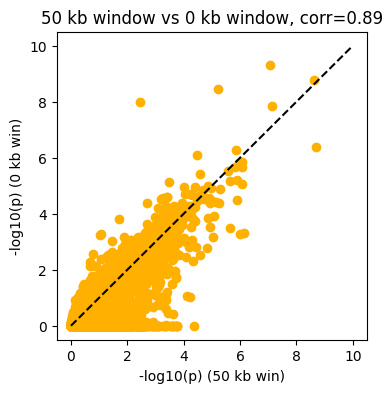

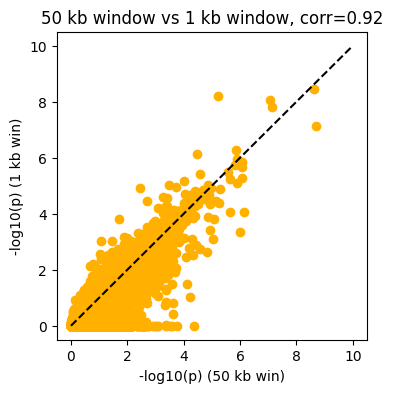

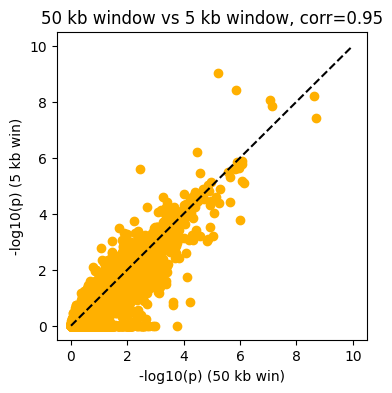

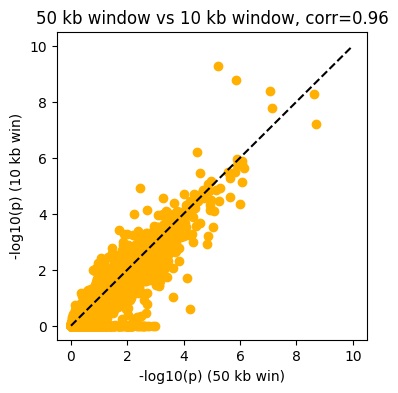

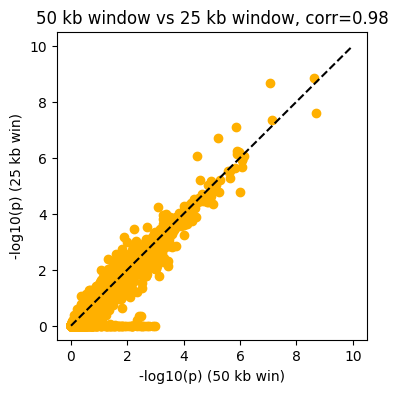

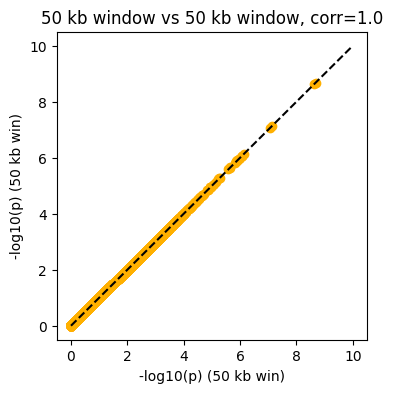

In [179]:
for w in list(loco.keys()):
    for w2 in list(loco.keys()):
        t=loco[w][['GENE','P','ZSTAT']].merge(loco[w2][['GENE','P','ZSTAT']],on='GENE',how='outer').fillna(1)
        corr_plt(t['P_x'],t['P_y'],'p')
        del(t)

### PVal- dropna

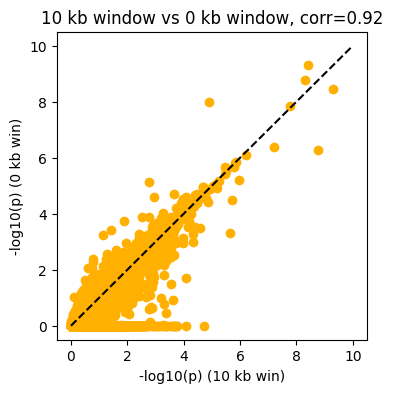

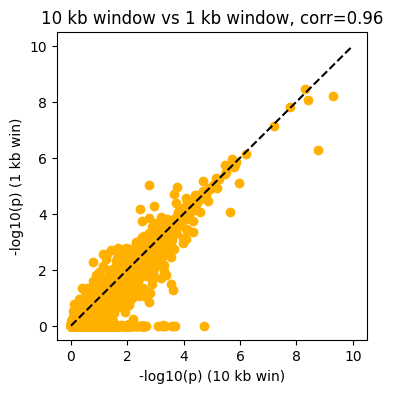

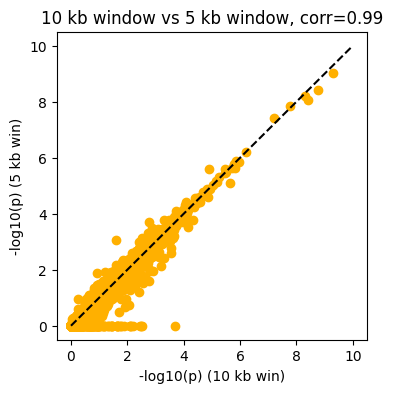

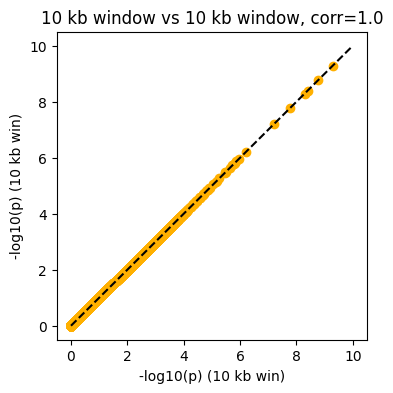

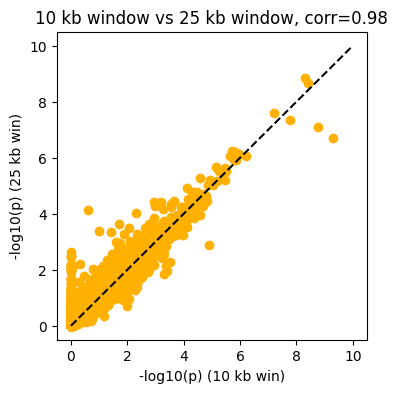

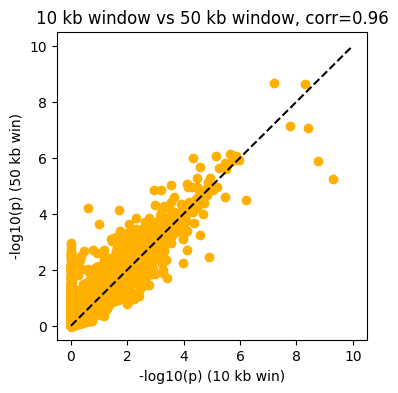

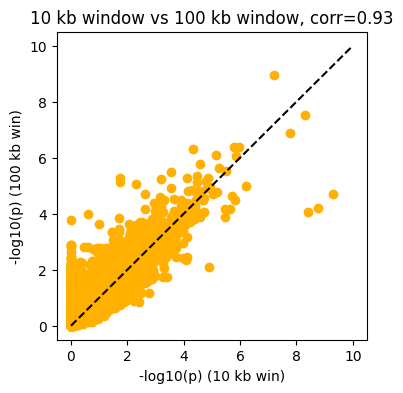

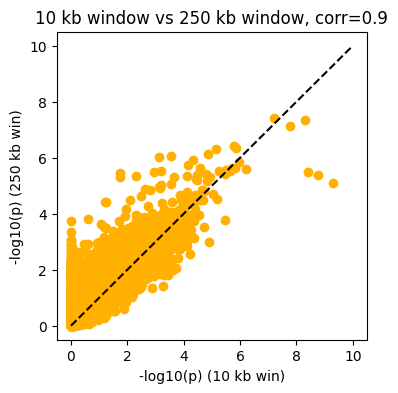

In [34]:

for w in [10]:
    for w2 in list(loco.keys()):
        t=loco[w][['GENE','P','ZSTAT']].merge(loco[w2][['GENE','P','ZSTAT']],on='GENE',how='outer').fillna(1)
        corr=corr_plt(t['P_x'],t['P_y'],stat='p')
        del(t)

/tmp/ipykernel_26855/3017383038.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(4,4))


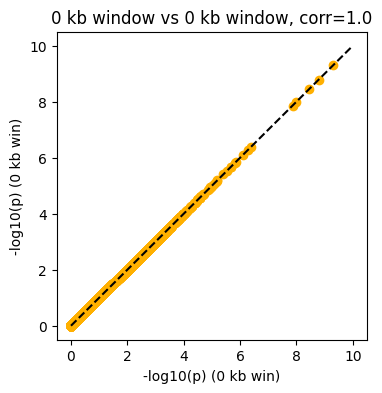

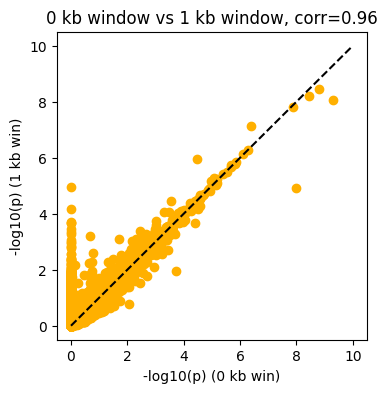

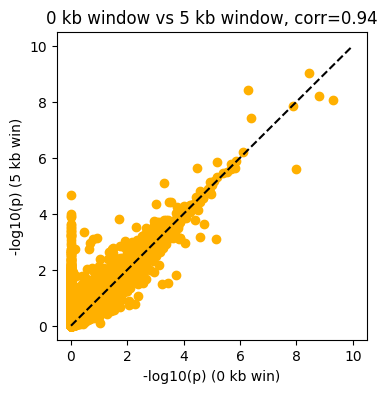

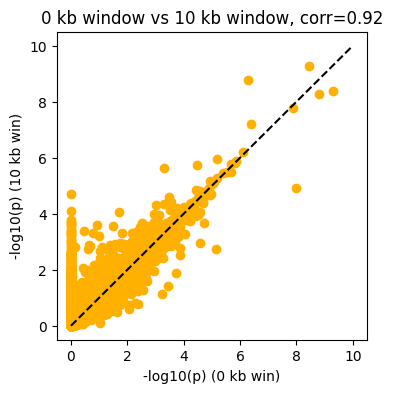

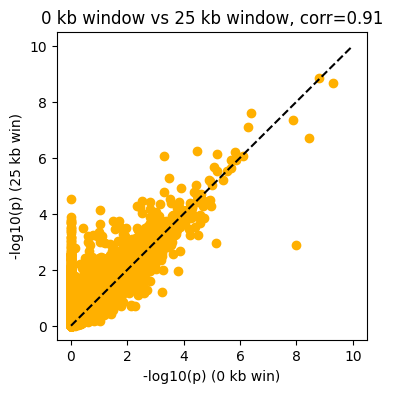

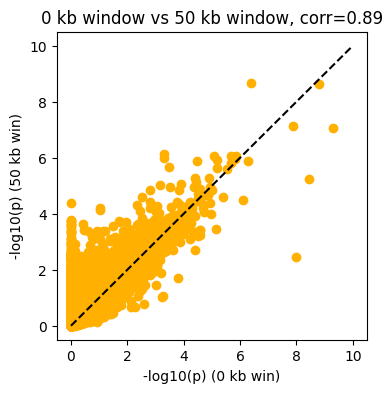

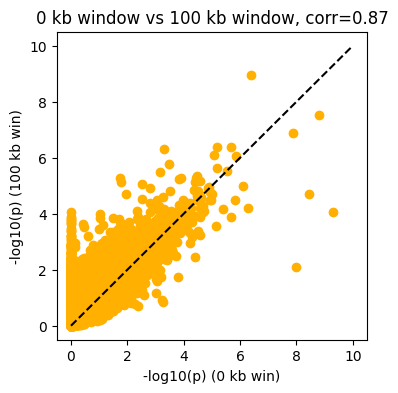

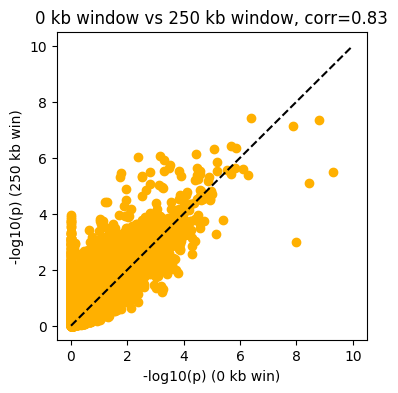

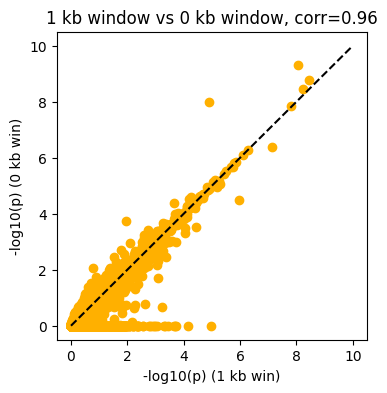

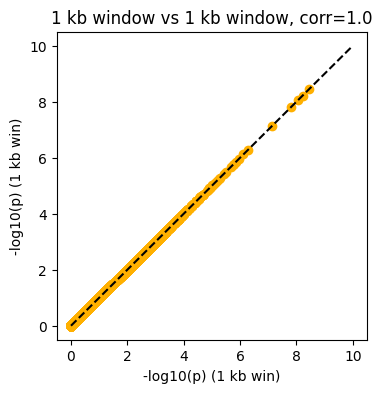

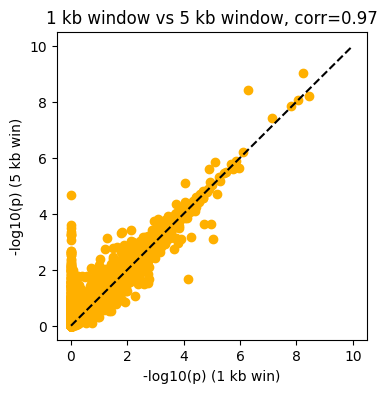

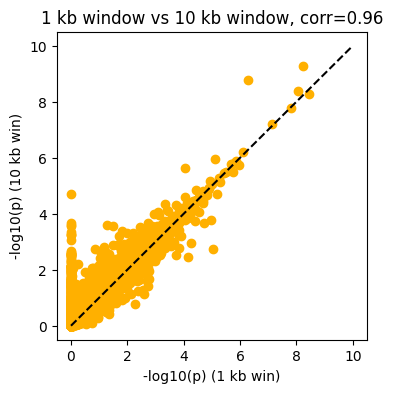

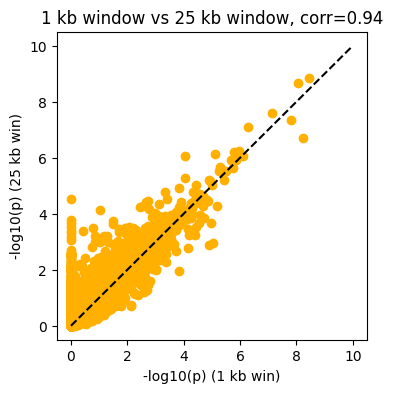

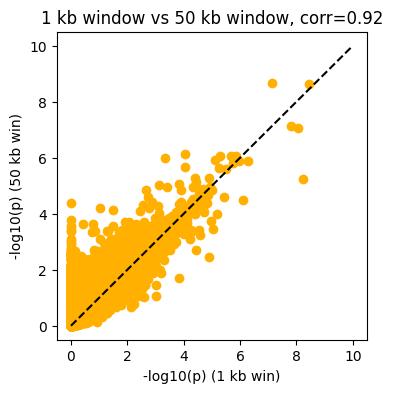

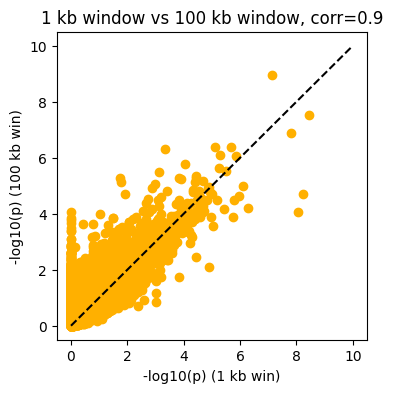

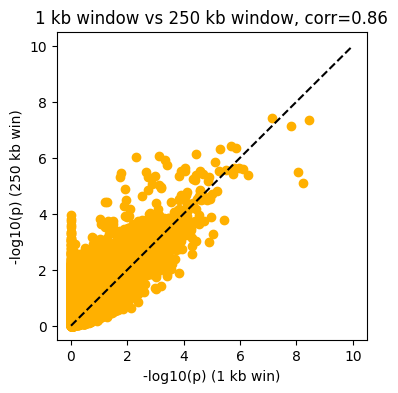

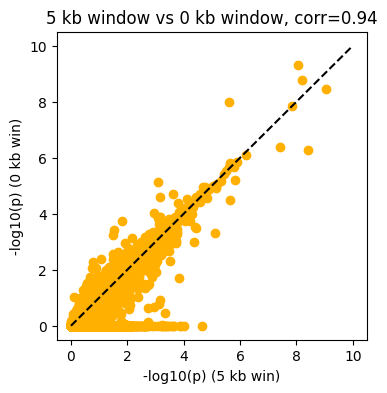

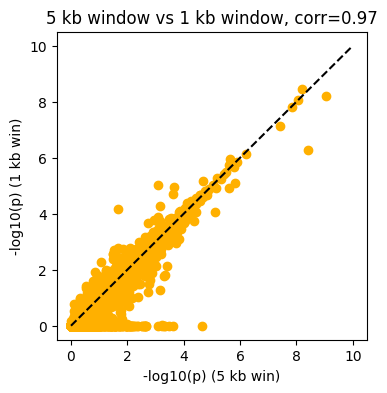

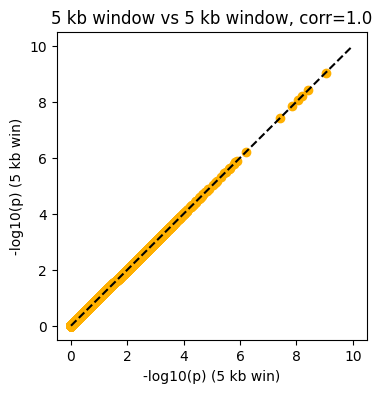

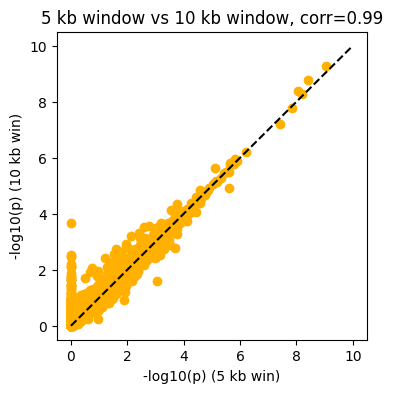

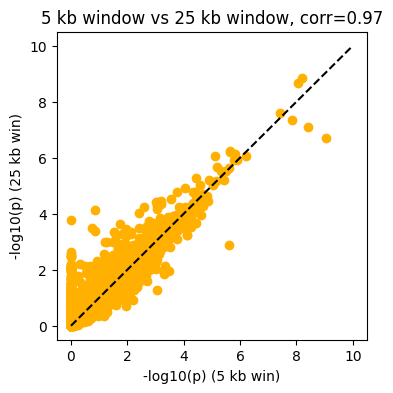

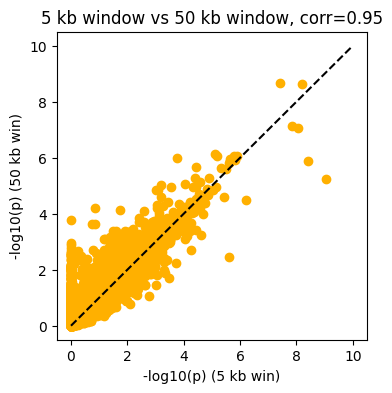

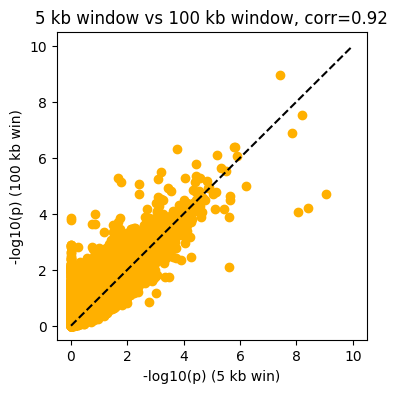

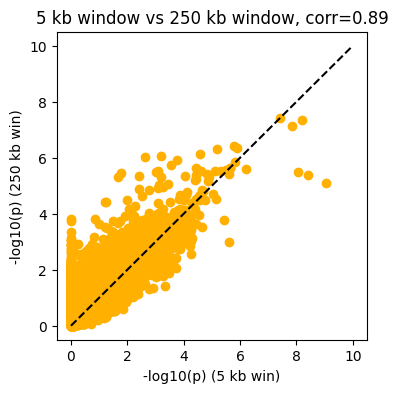

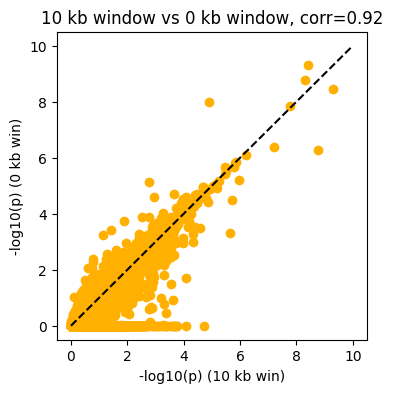

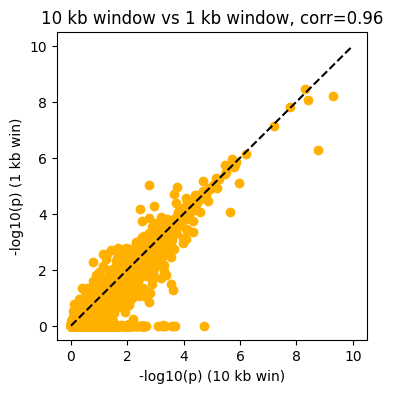

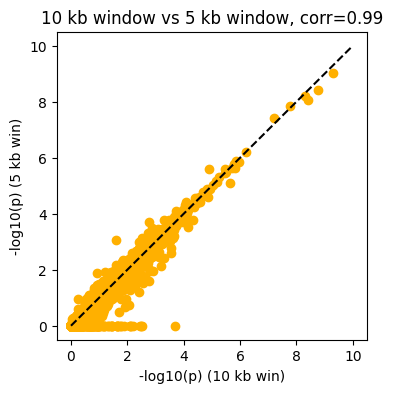

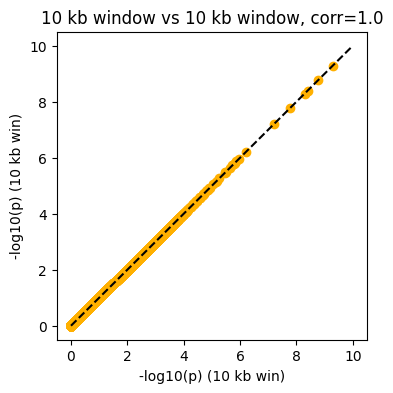

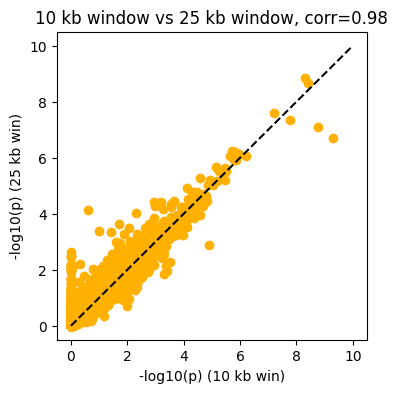

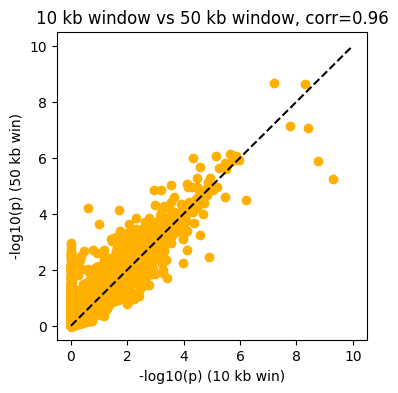

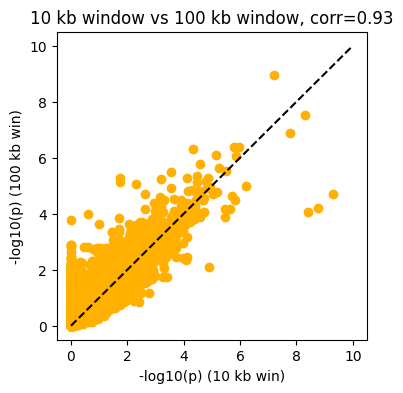

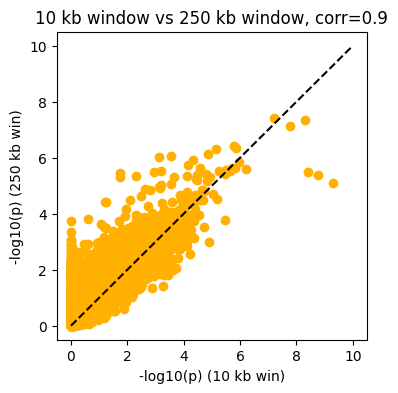

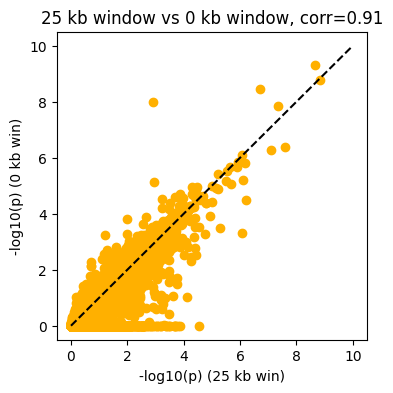

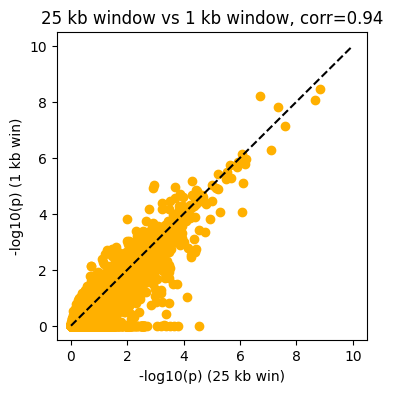

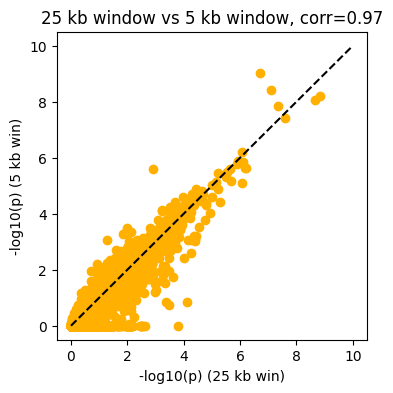

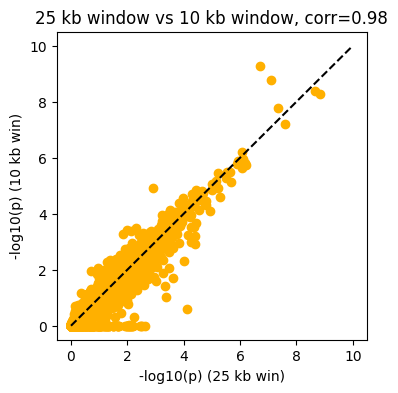

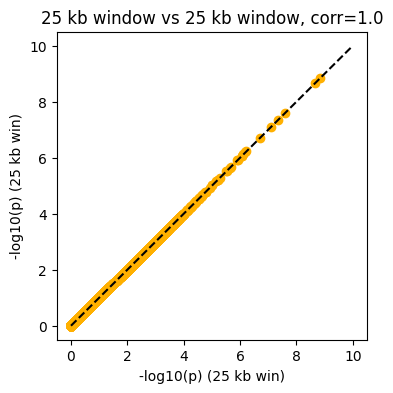

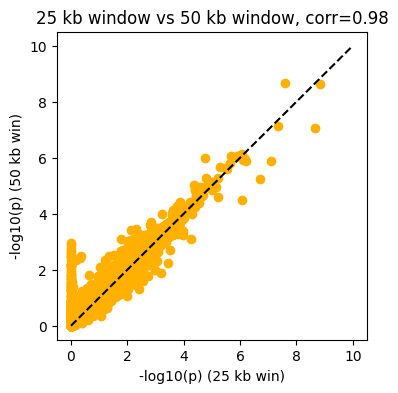

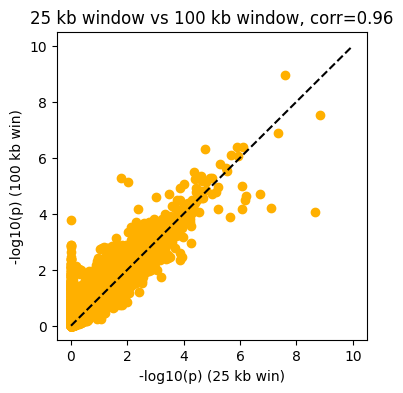

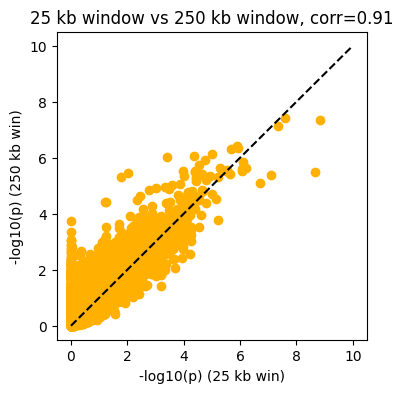

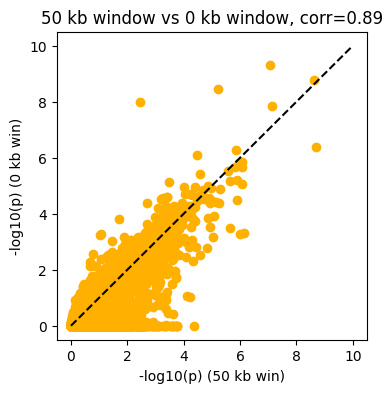

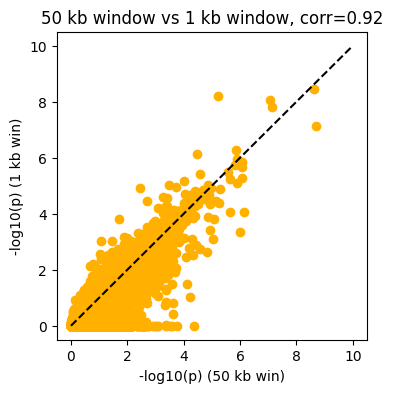

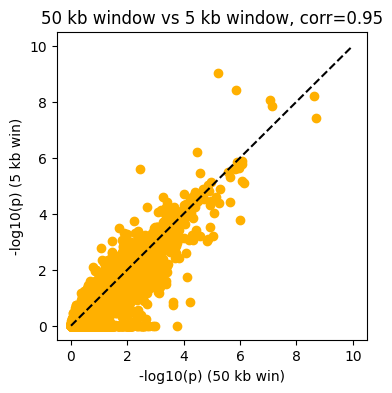

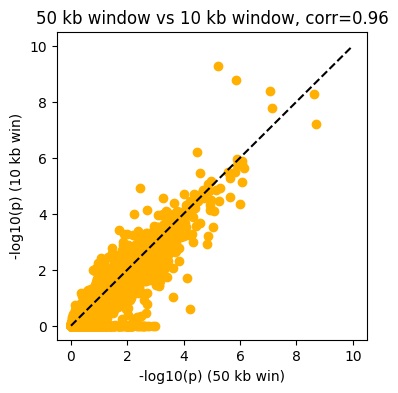

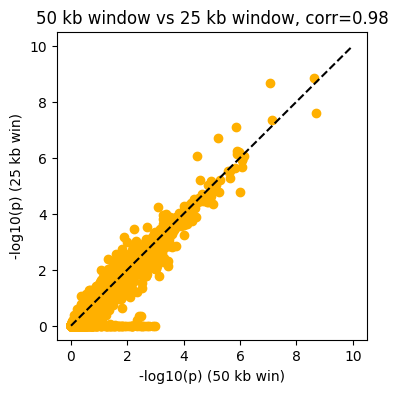

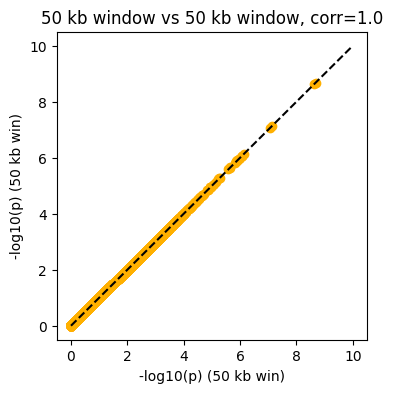

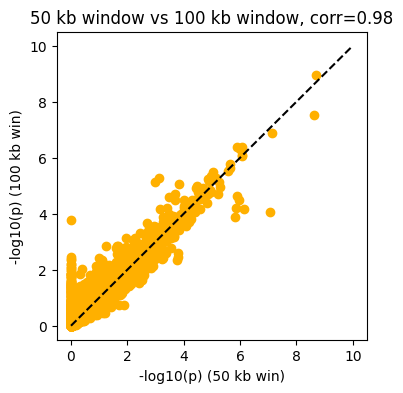

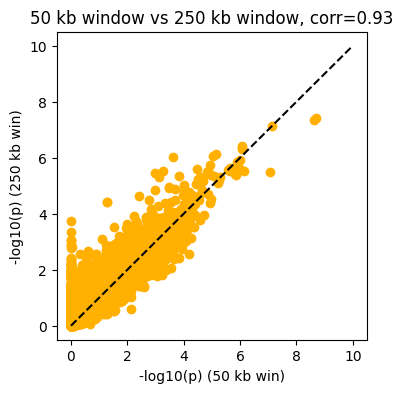

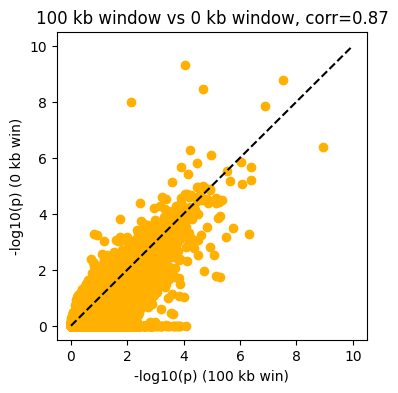

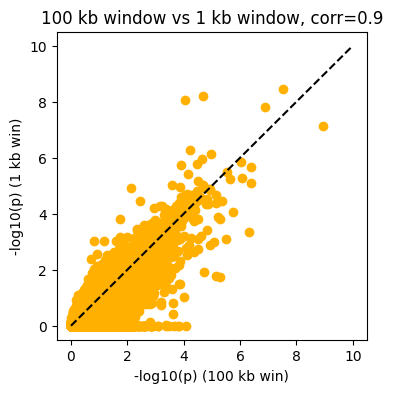

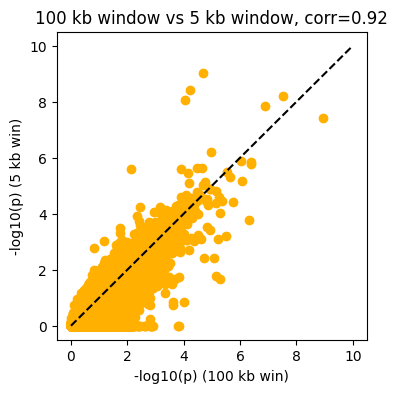

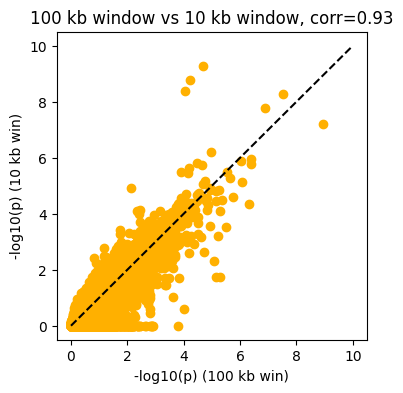

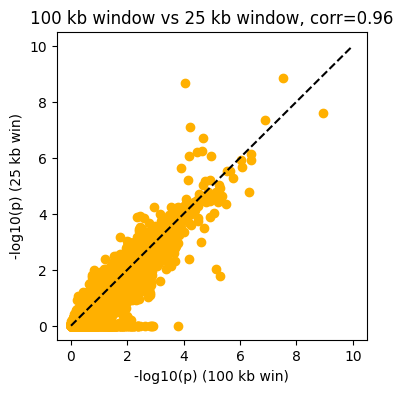

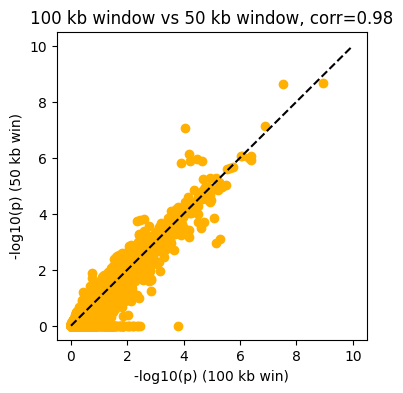

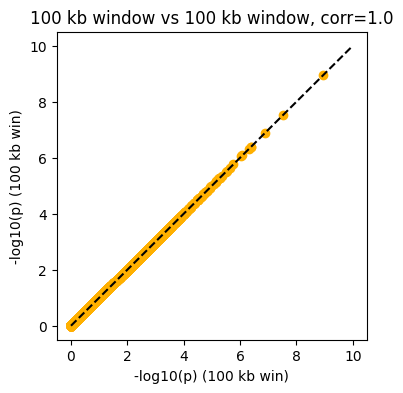

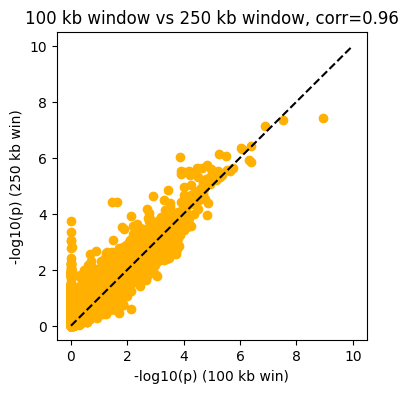

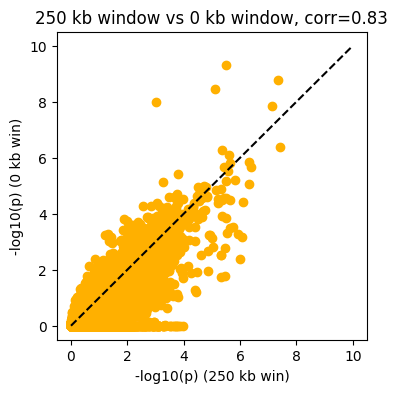

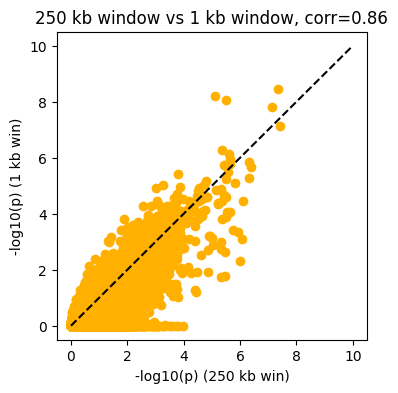

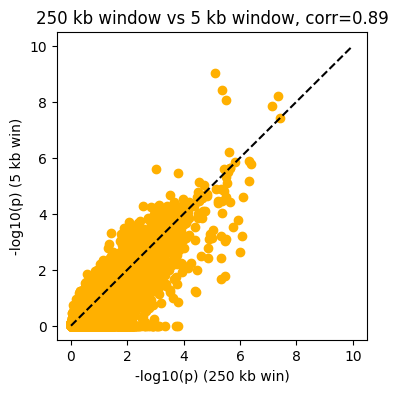

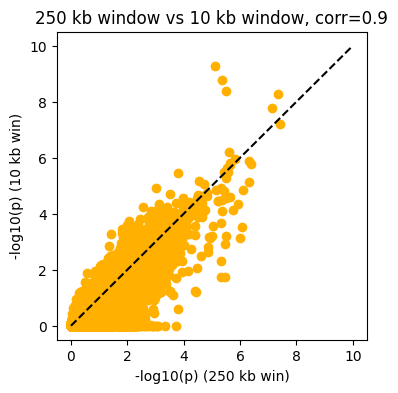

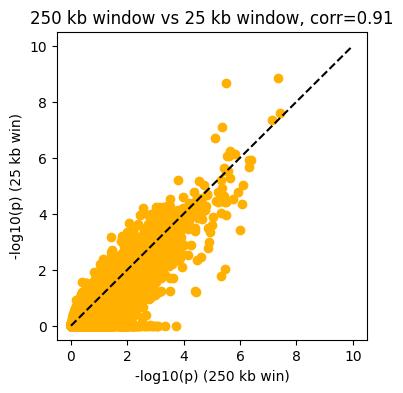

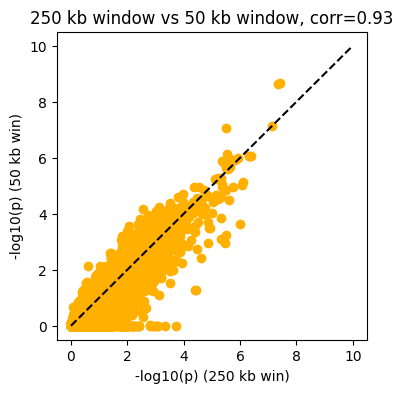

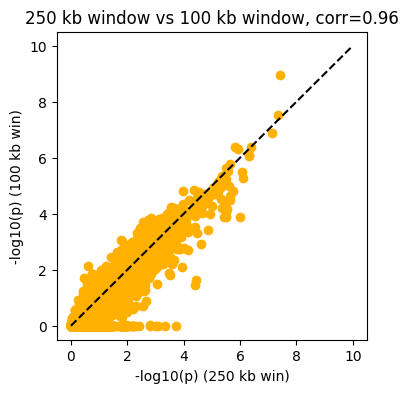

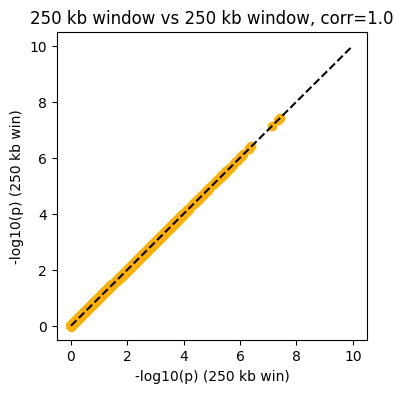

In [35]:

for w in list(loco.keys()):
    for w2 in list(loco.keys()):
        t=loco[w][['GENE','P','ZSTAT']].merge(loco[w2][['GENE','P','ZSTAT']],on='GENE',how='outer').fillna(1)
        corr=corr_plt(t['P_x'],t['P_y'],'p')
        del(t)

### ZSTAT

/tmp/ipykernel_26855/2206202902.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(4,4))


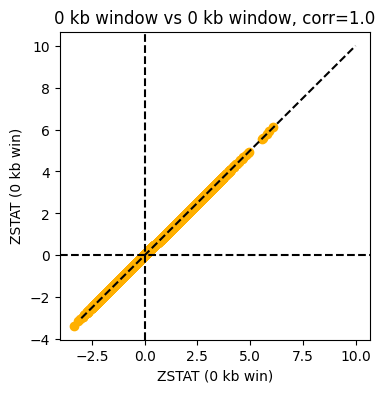

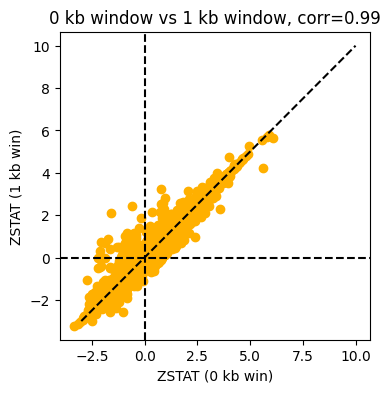

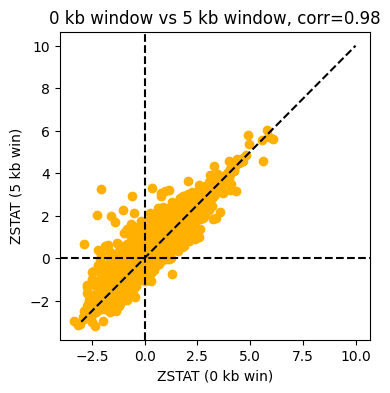

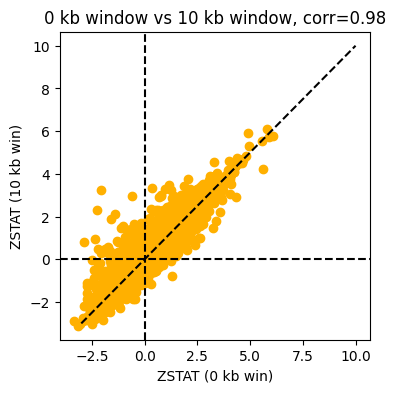

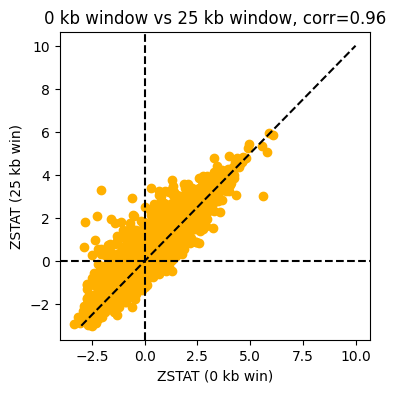

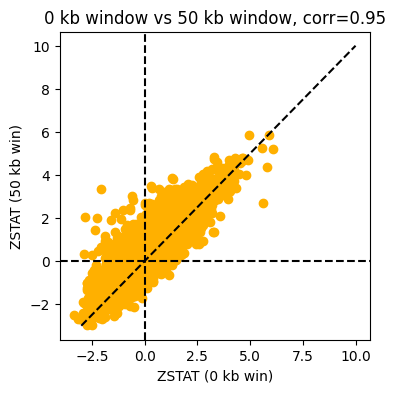

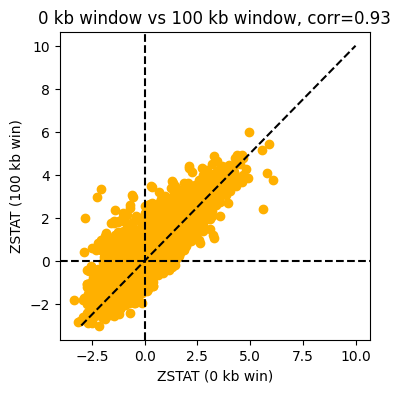

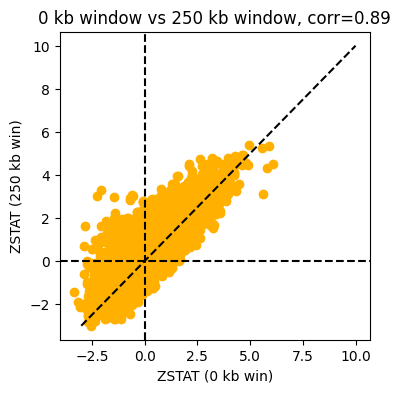

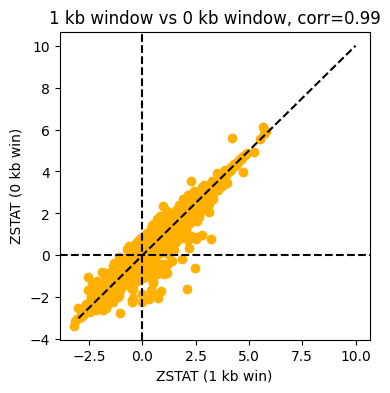

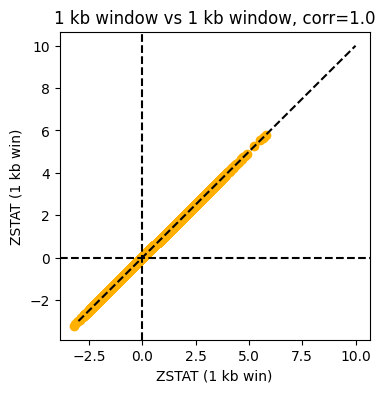

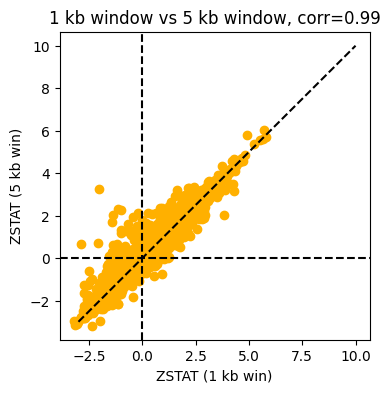

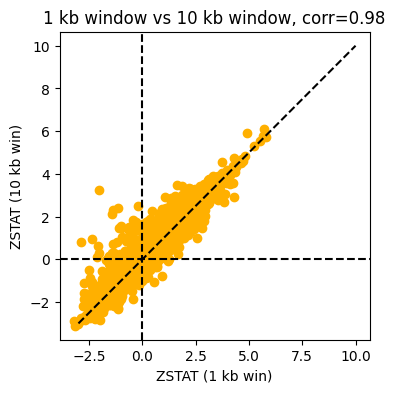

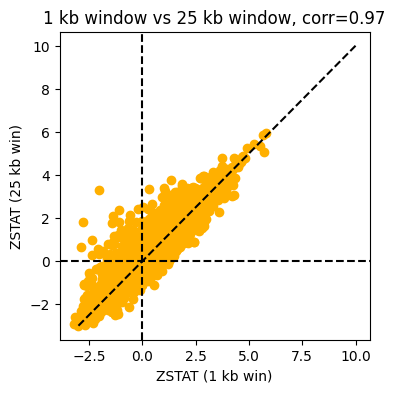

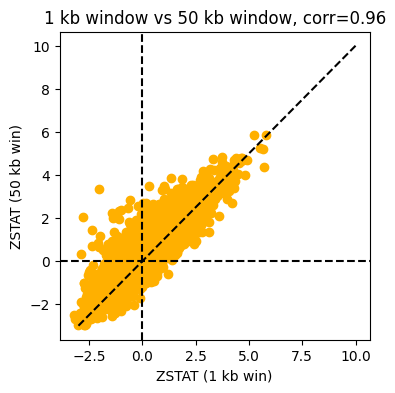

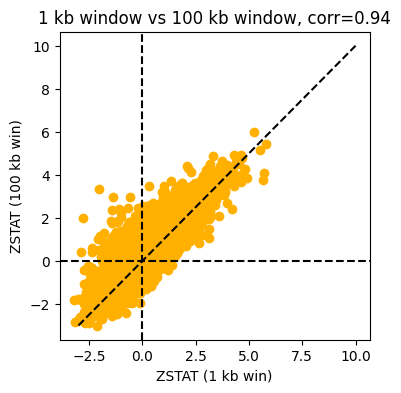

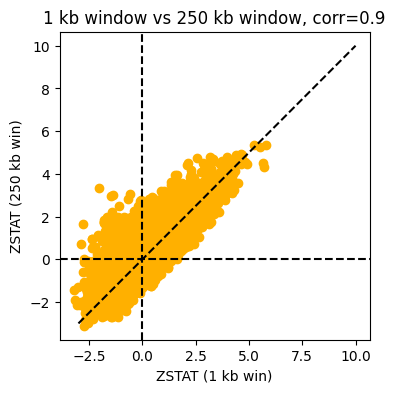

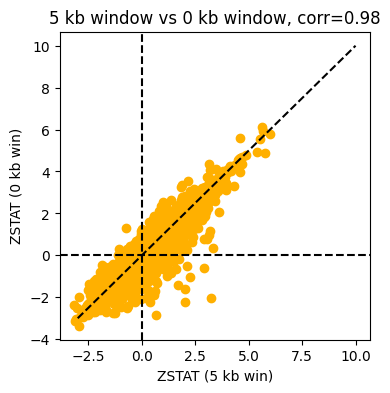

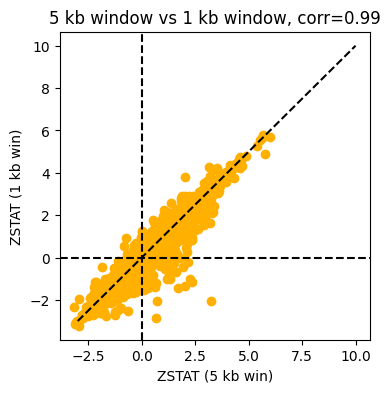

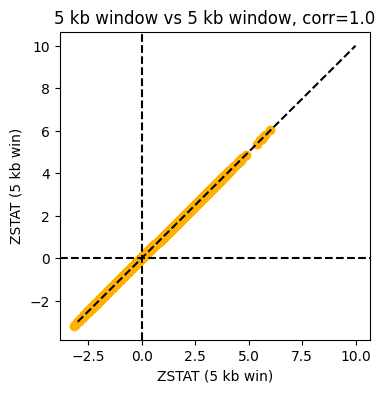

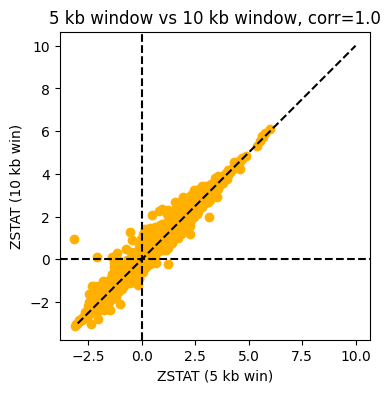

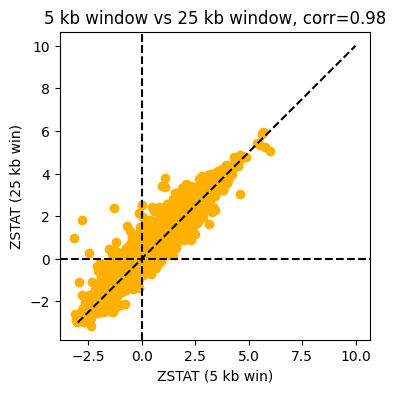

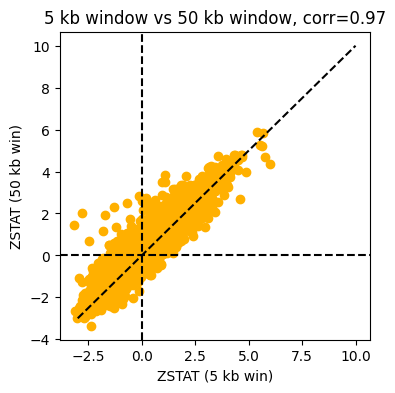

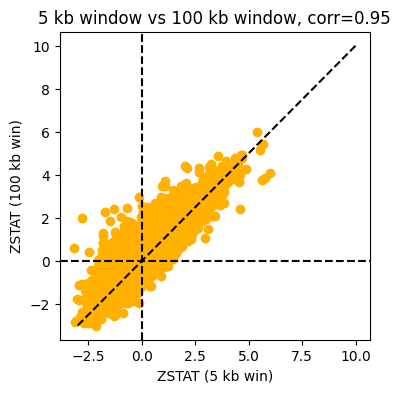

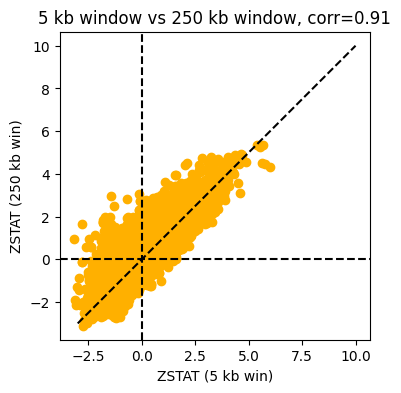

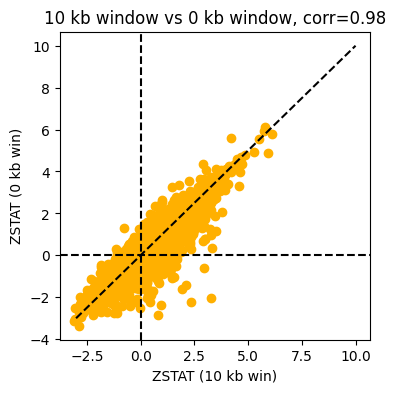

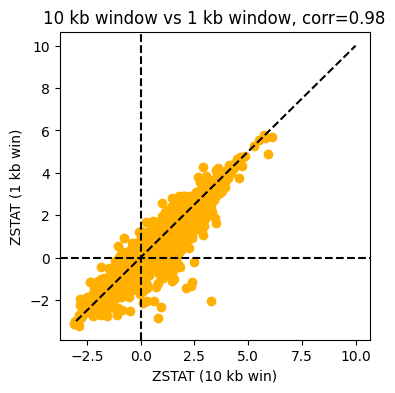

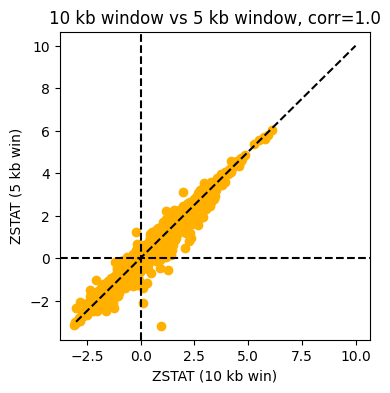

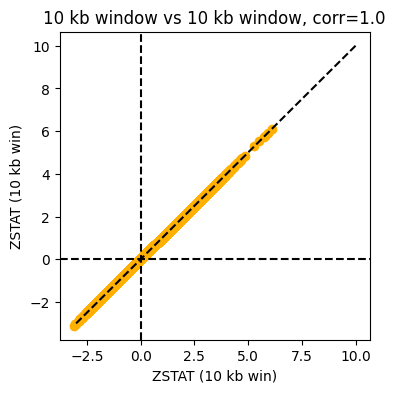

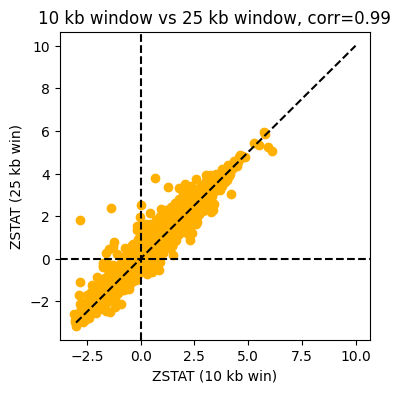

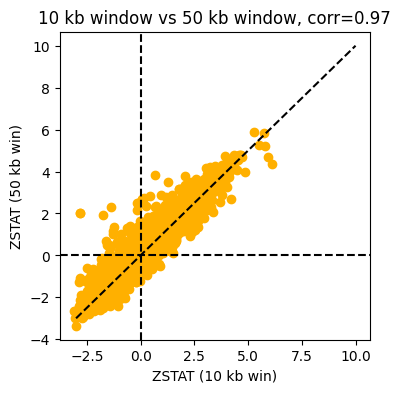

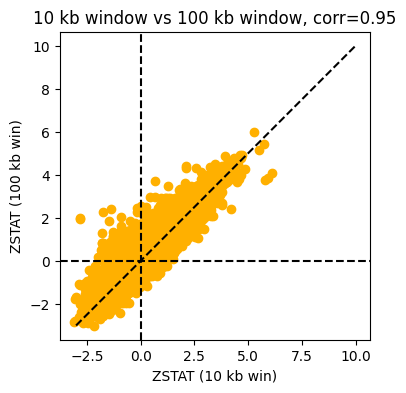

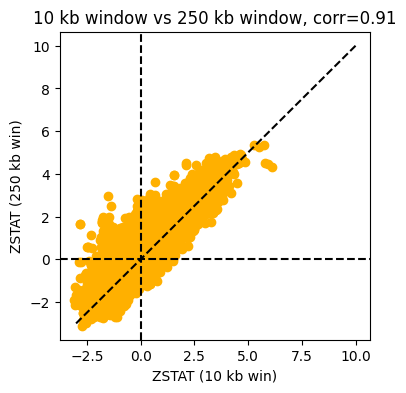

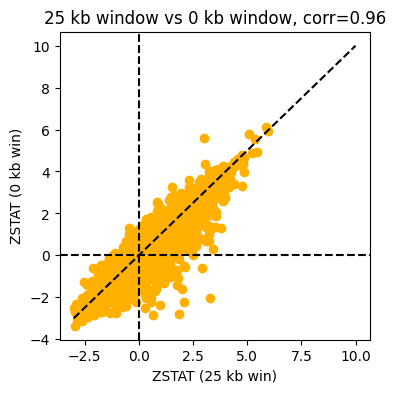

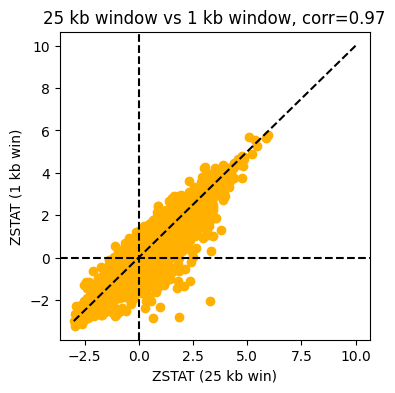

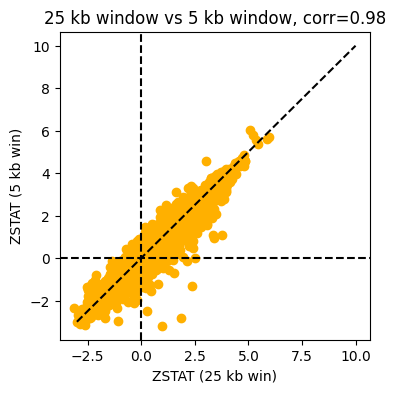

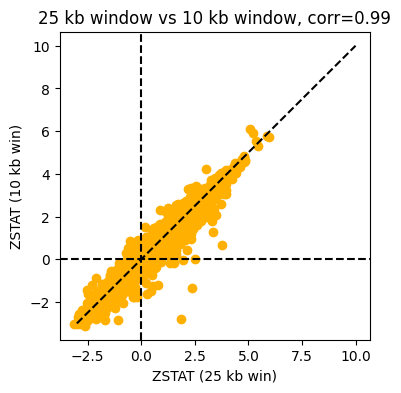

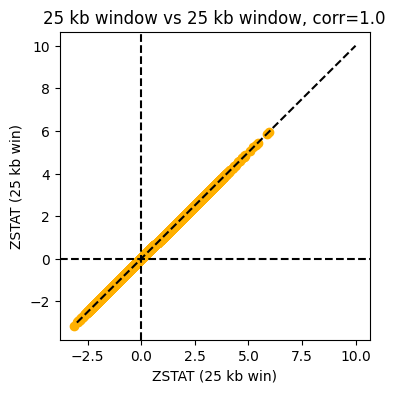

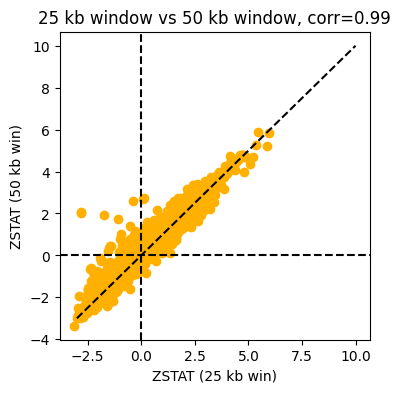

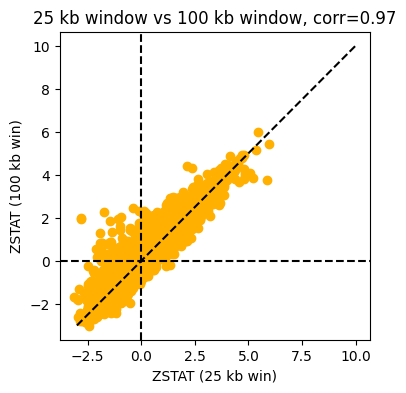

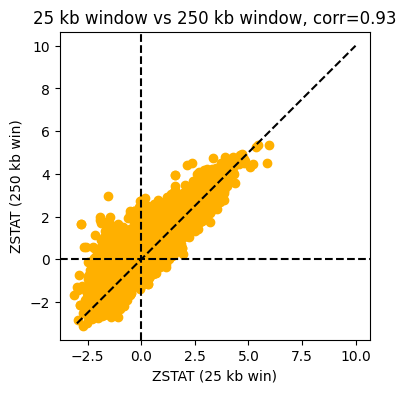

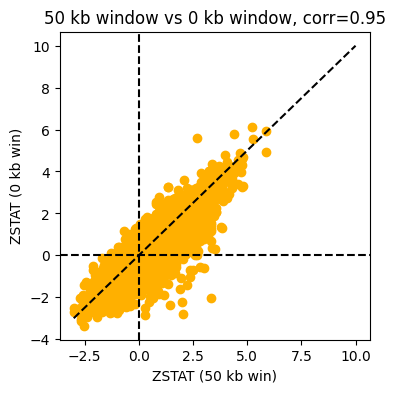

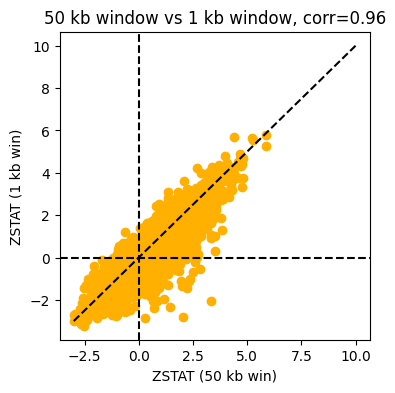

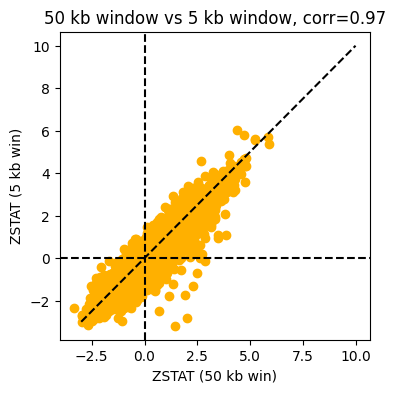

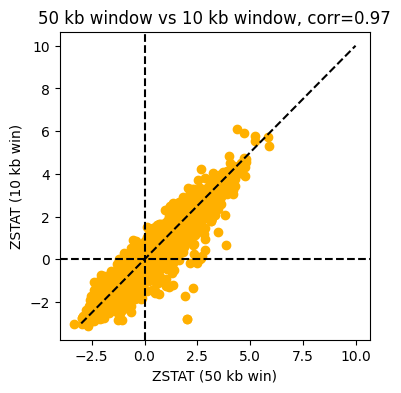

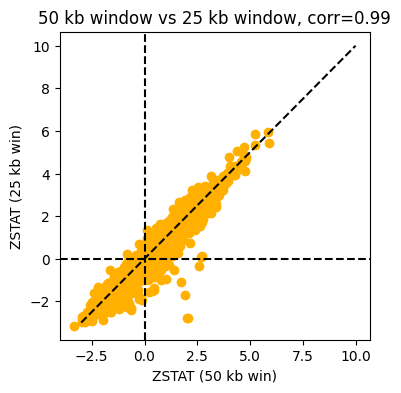

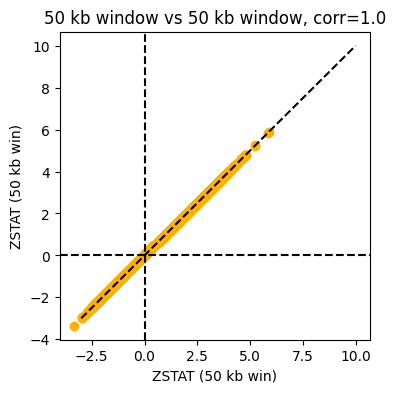

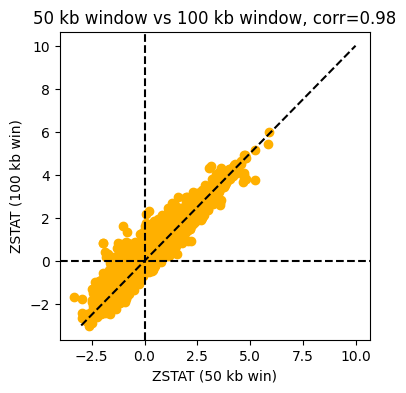

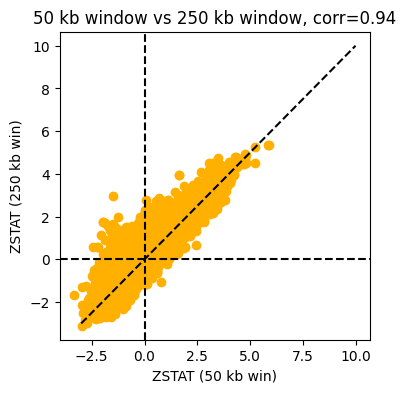

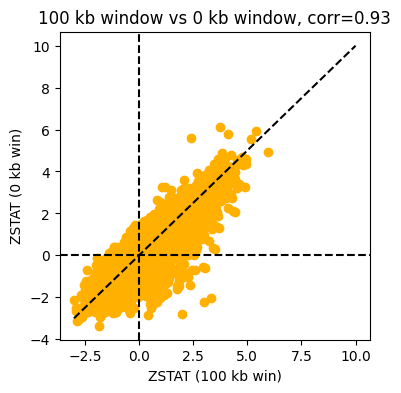

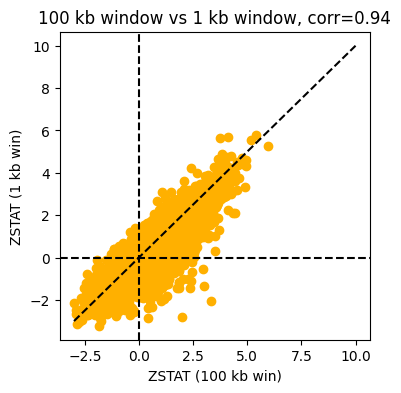

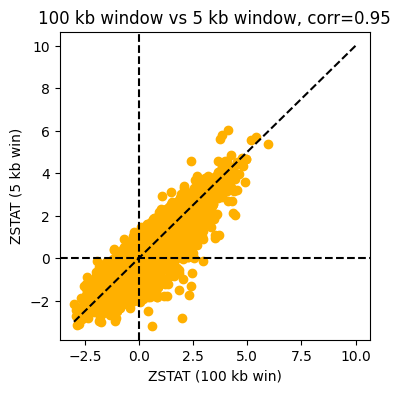

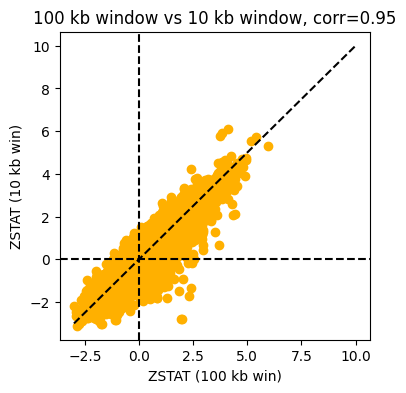

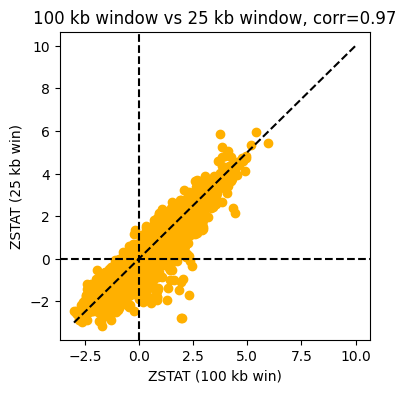

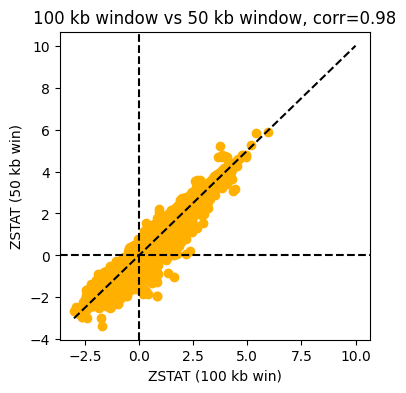

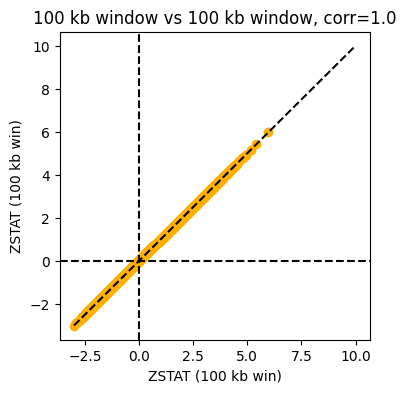

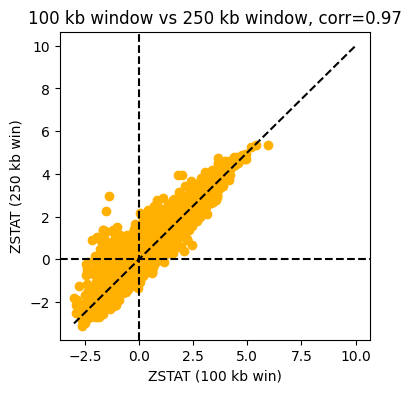

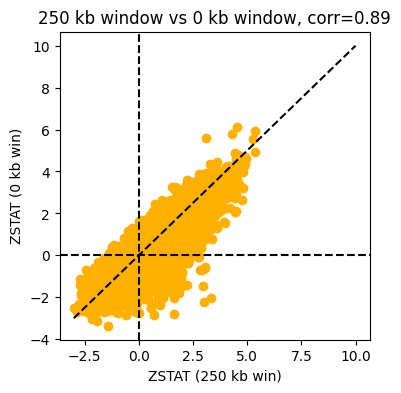

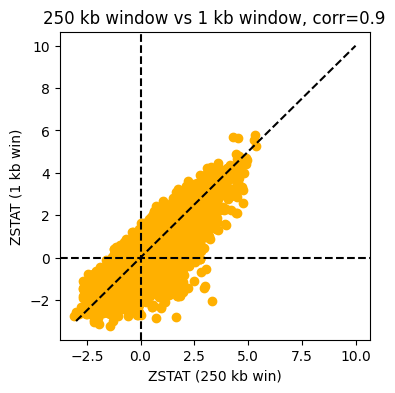

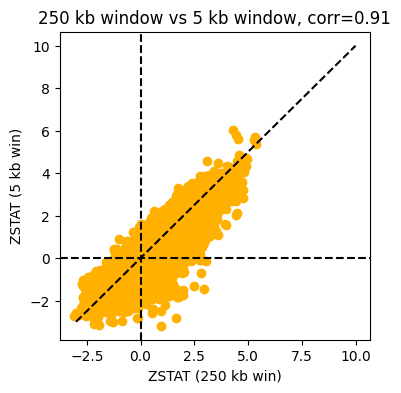

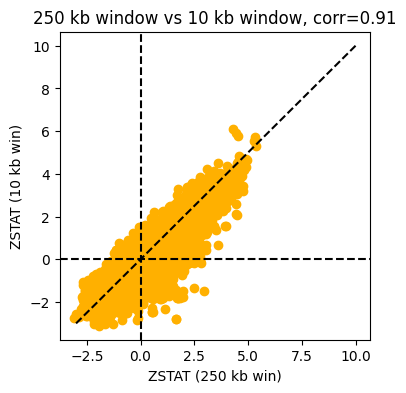

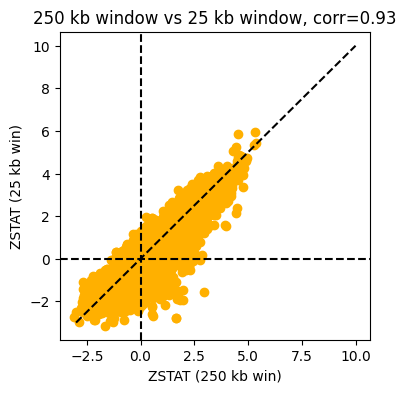

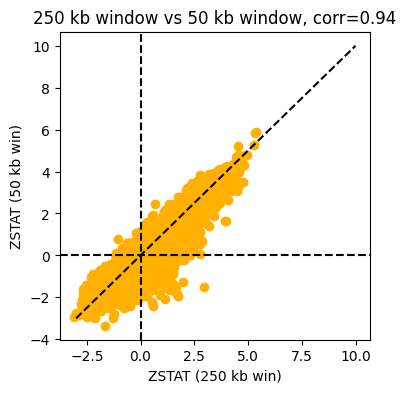

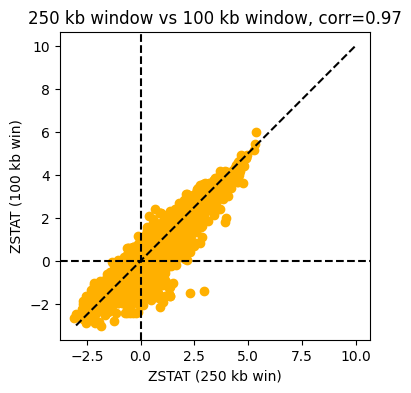

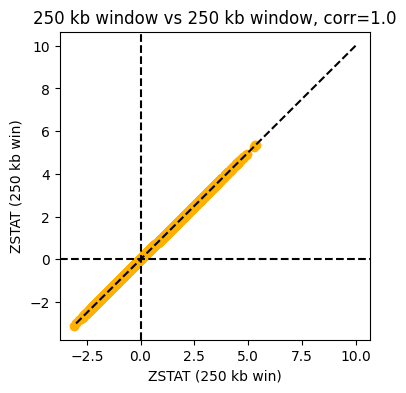

In [29]:
for w in list(loco.keys()):
    for w2 in list(loco.keys()):
        t=loco[w][['GENE','P','ZSTAT']].merge(loco[w2][['GENE','P','ZSTAT']],on='GENE',how='outer').dropna()
        corr_plt(t['ZSTAT_x'],t['ZSTAT_y'],'z')
        del(t)

/tmp/ipykernel_2360972/4132088933.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig=plt.figure(figsize=(4,4))


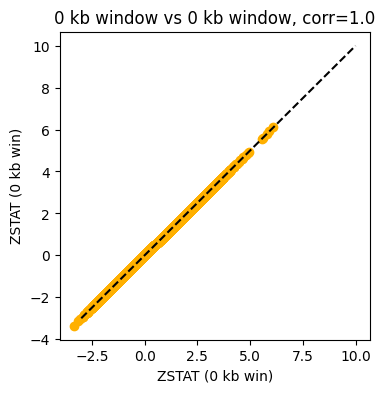

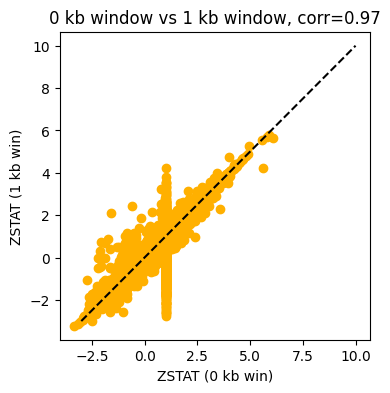

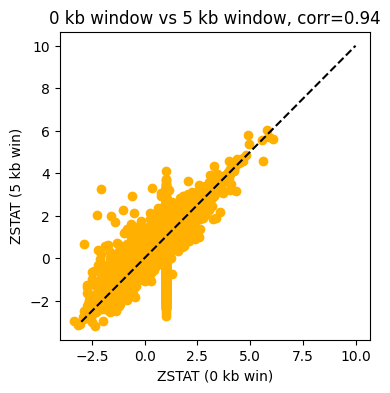

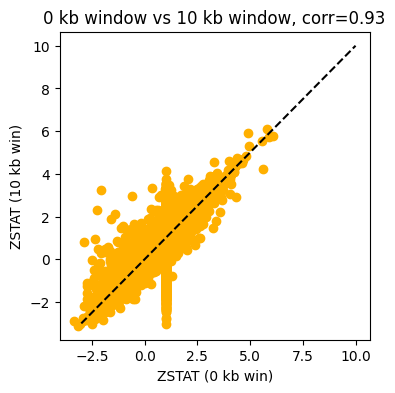

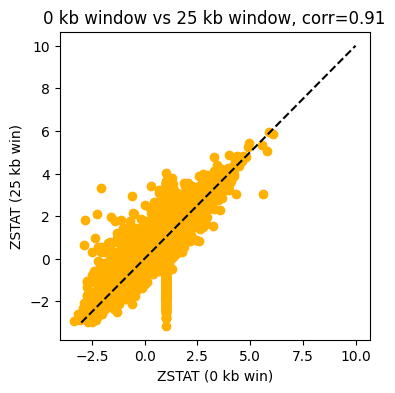

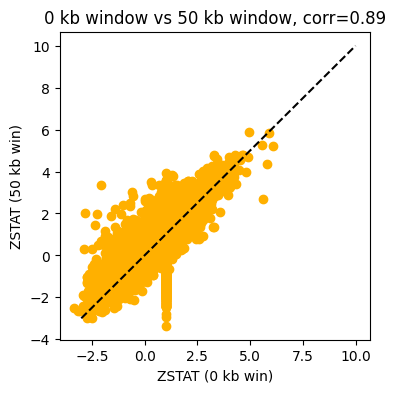

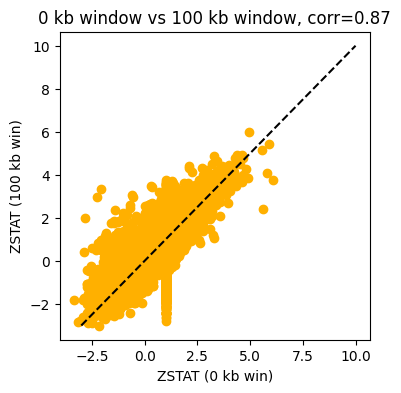

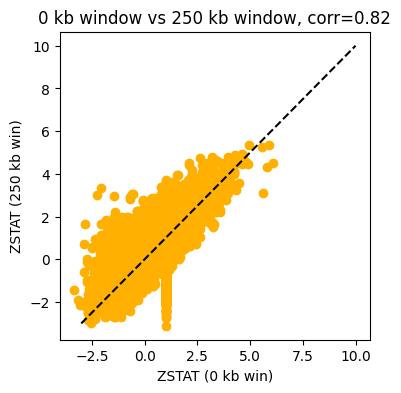

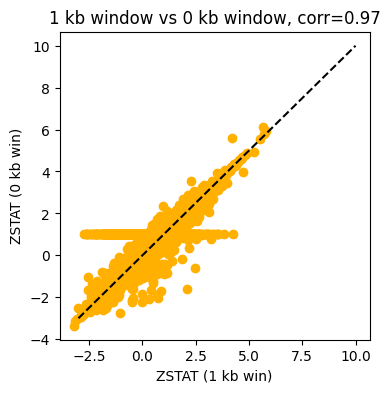

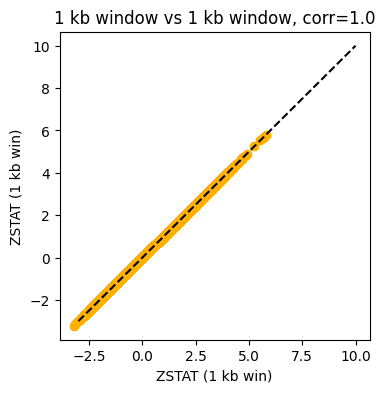

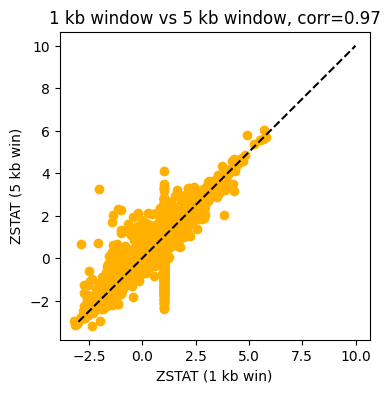

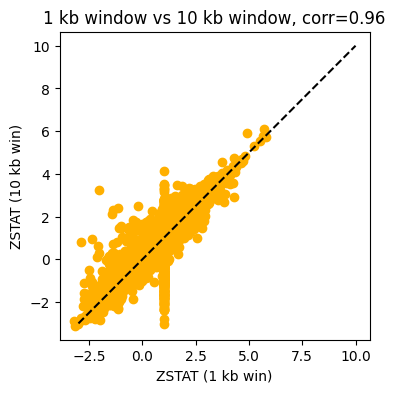

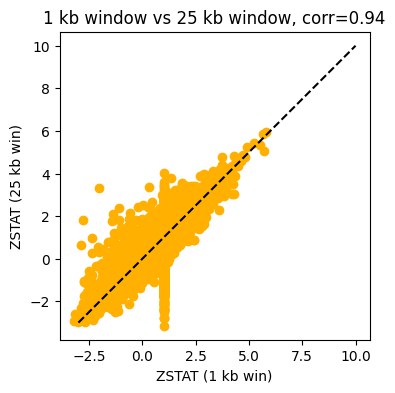

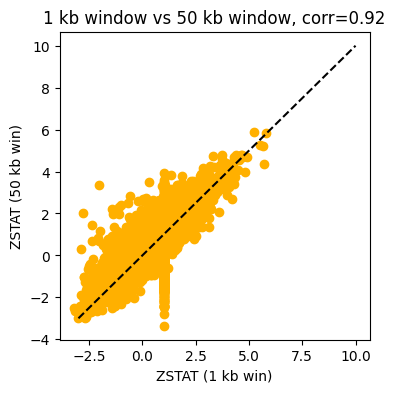

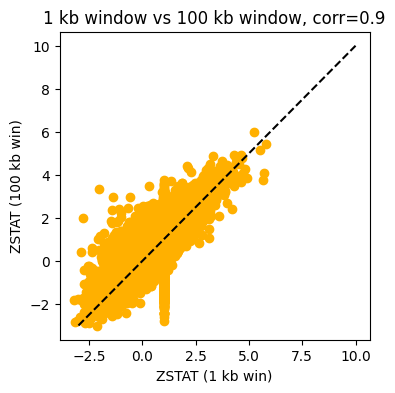

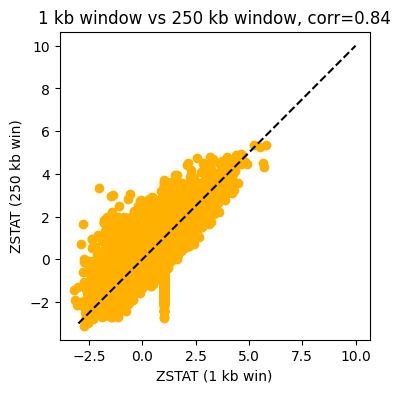

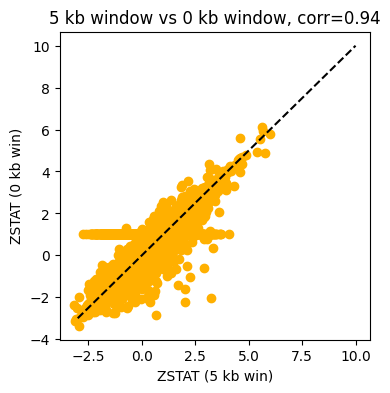

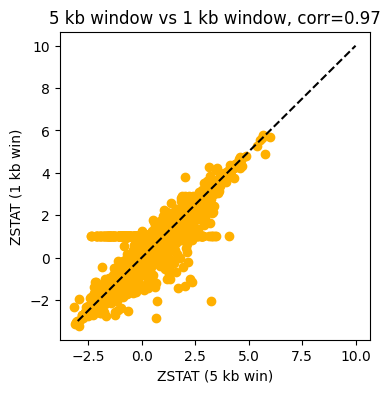

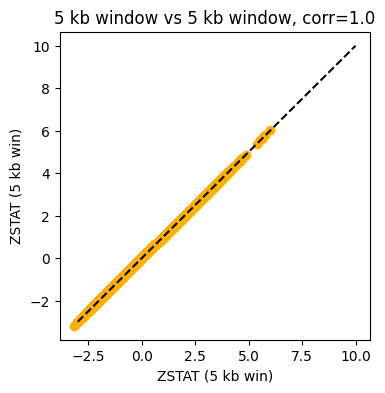

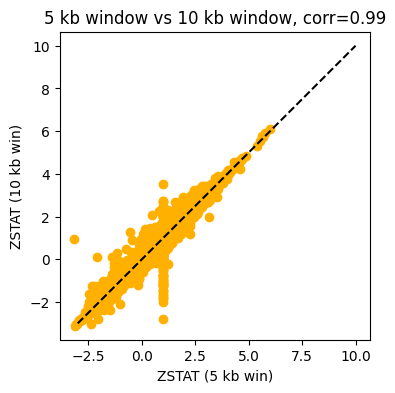

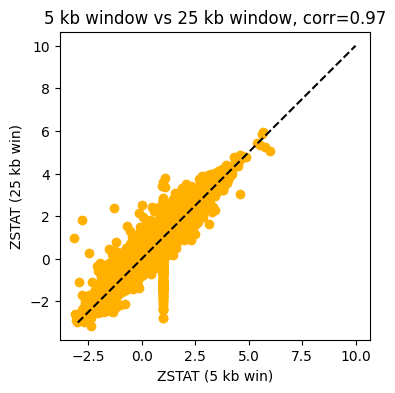

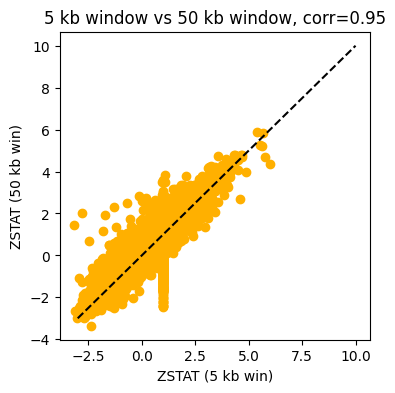

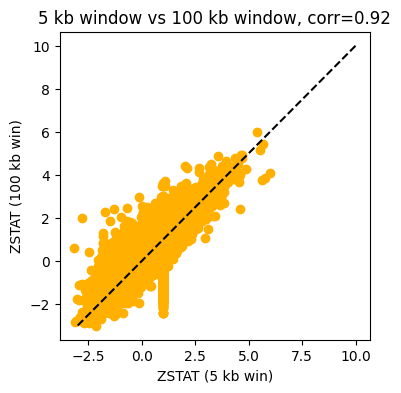

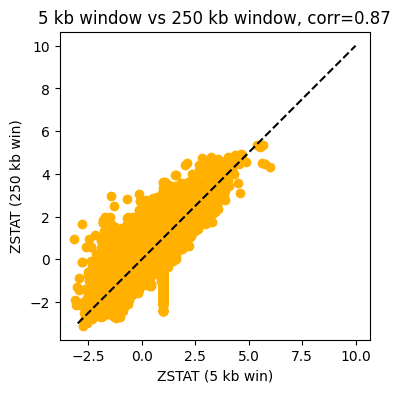

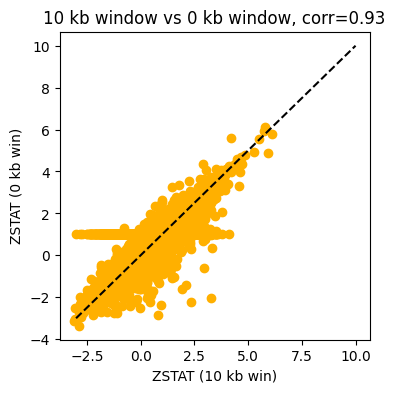

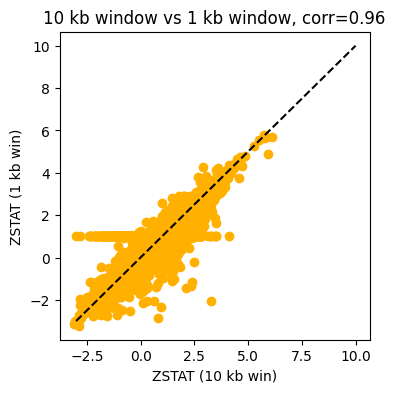

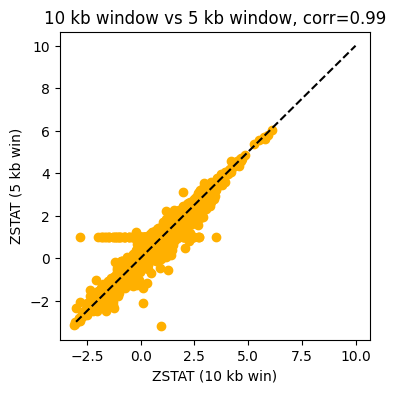

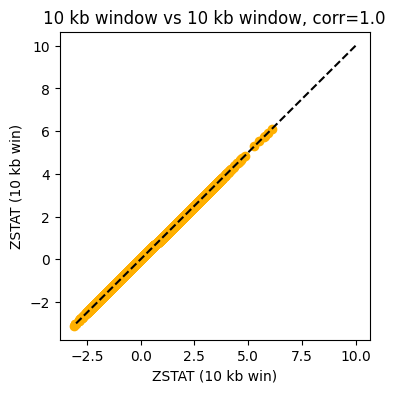

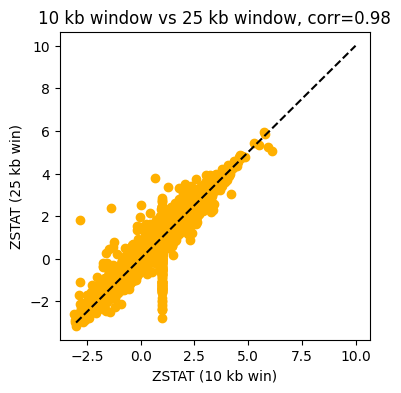

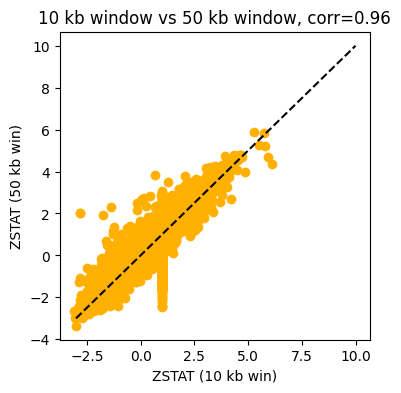

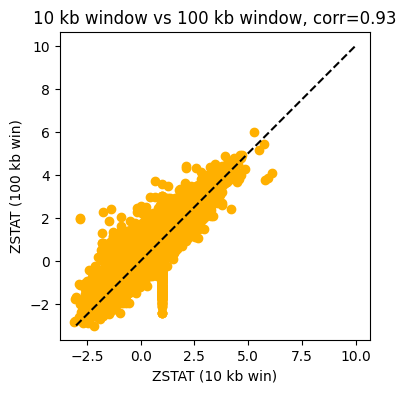

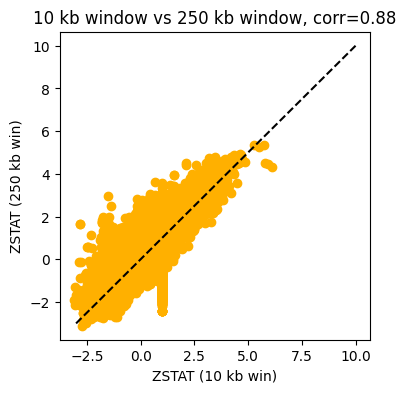

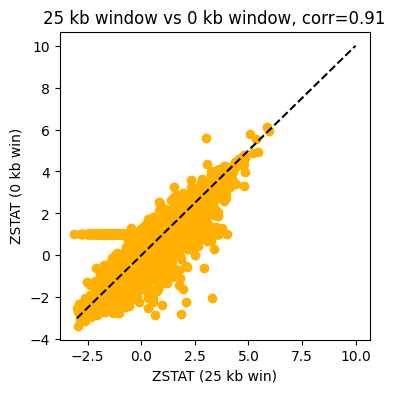

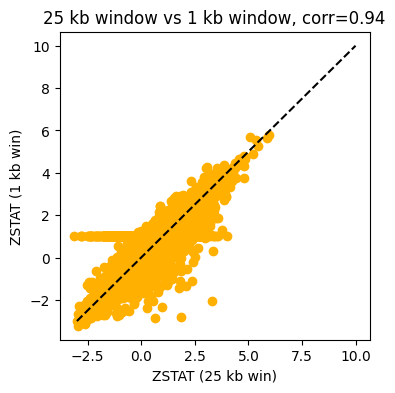

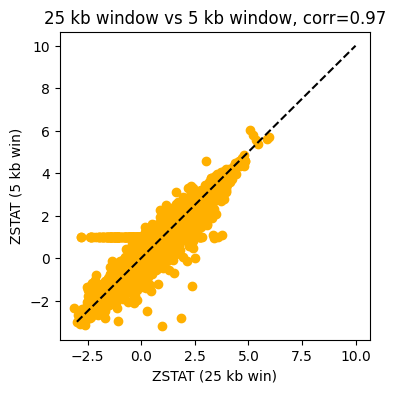

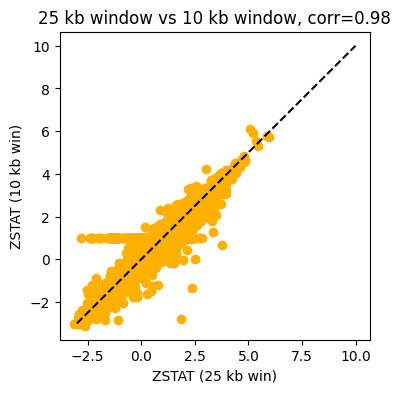

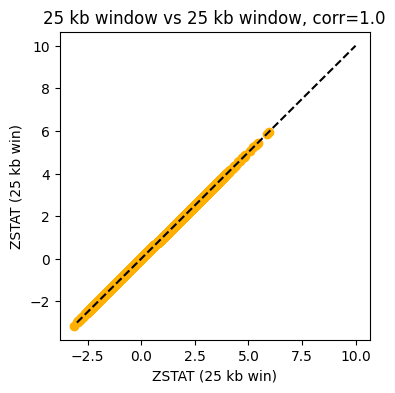

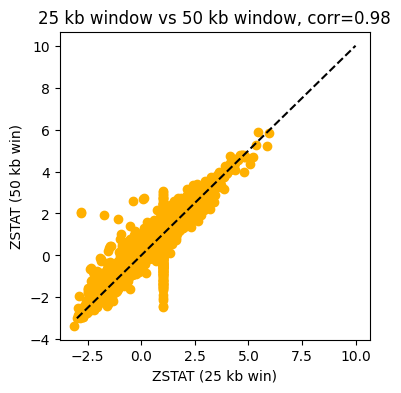

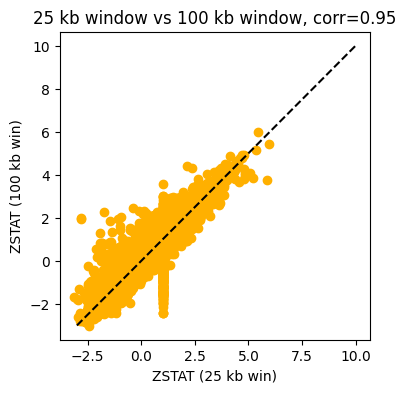

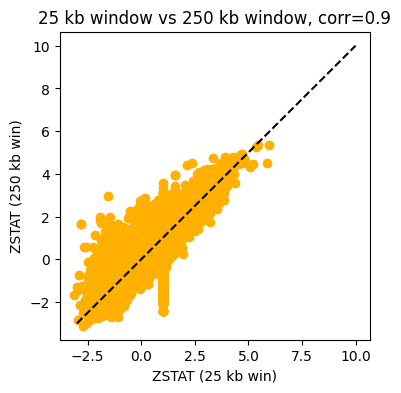

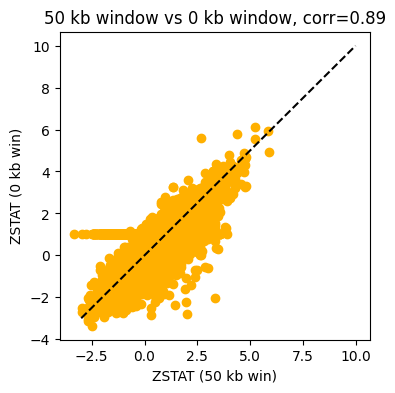

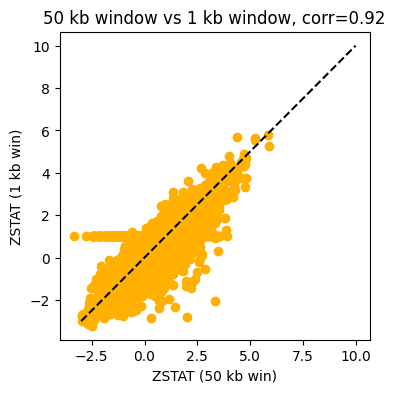

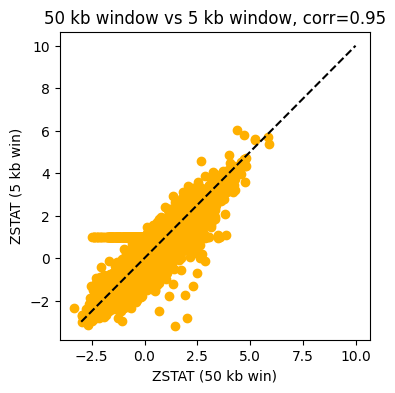

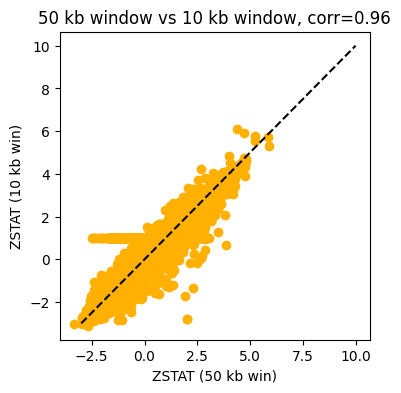

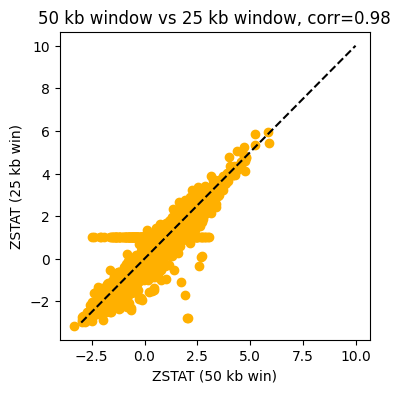

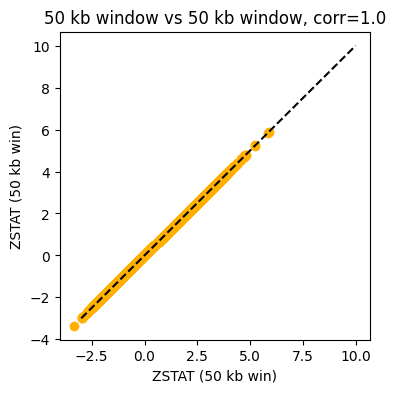

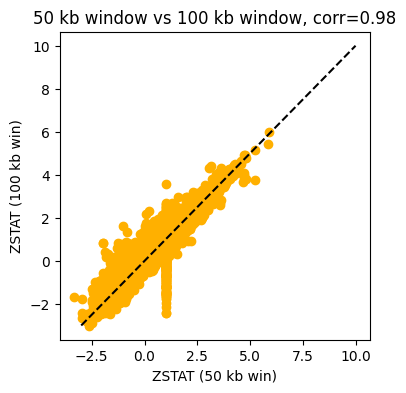

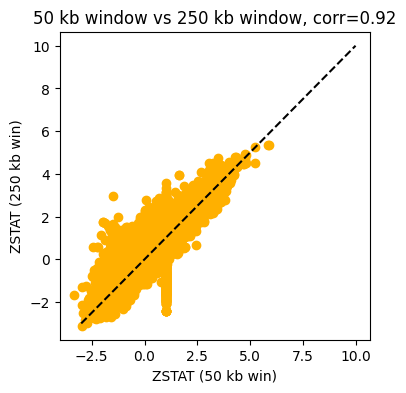

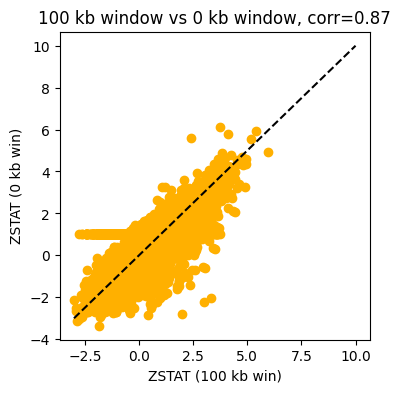

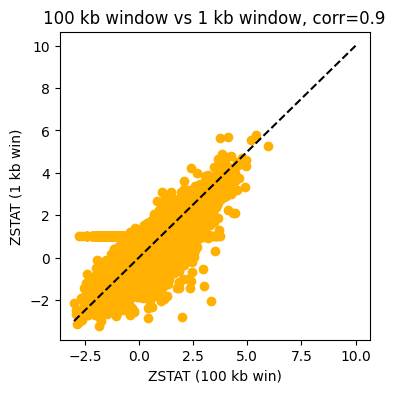

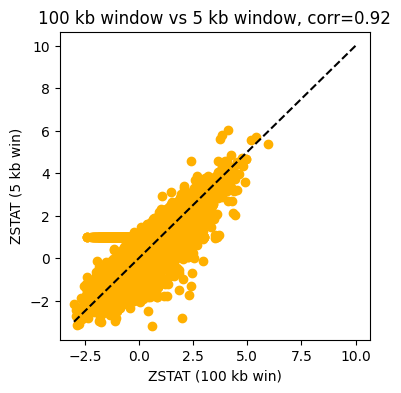

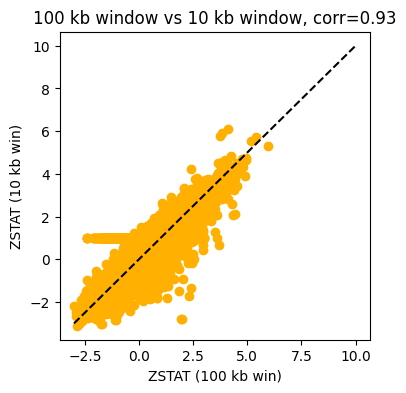

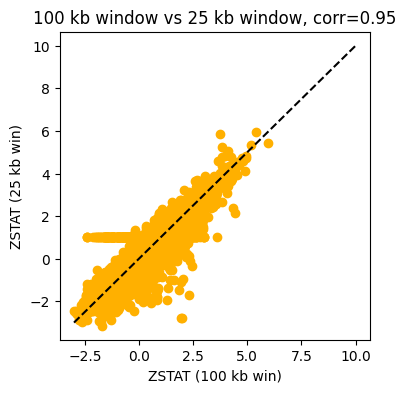

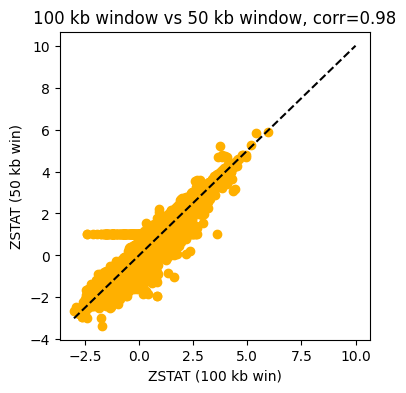

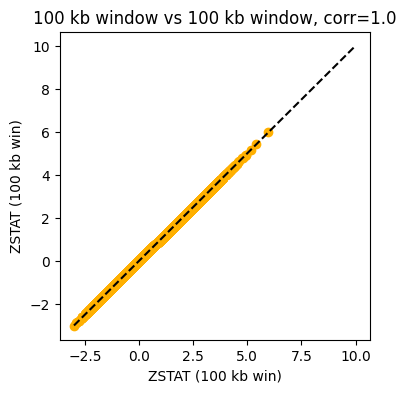

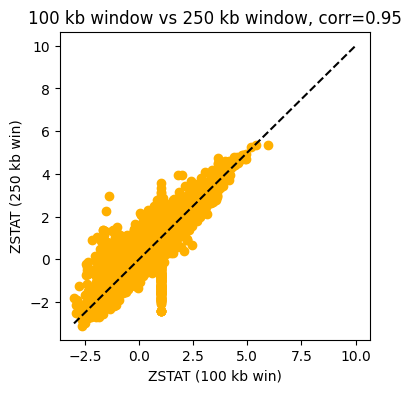

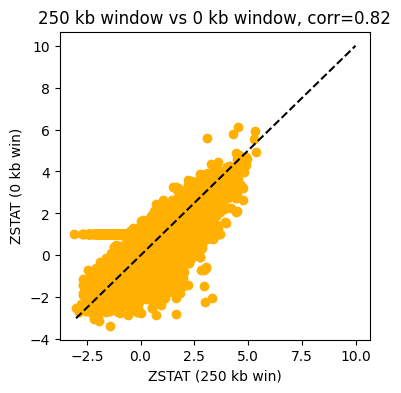

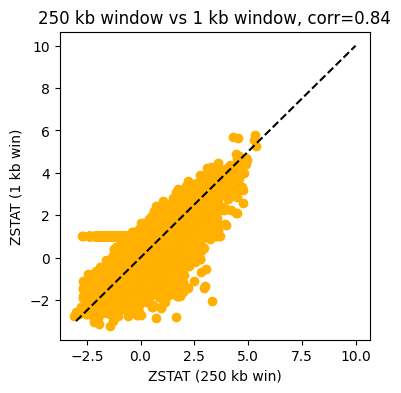

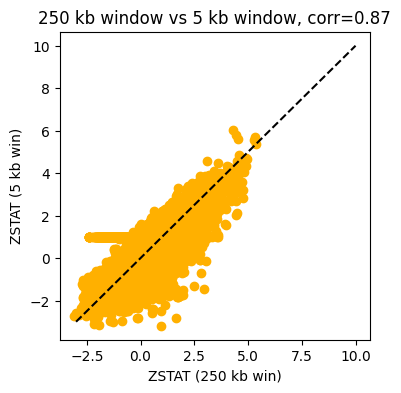

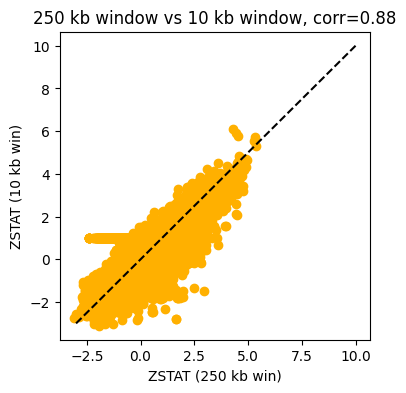

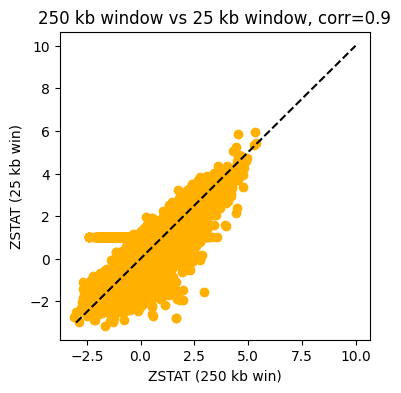

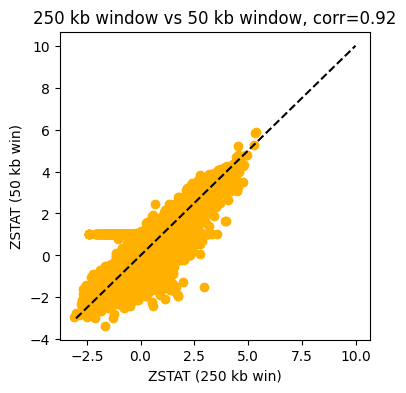

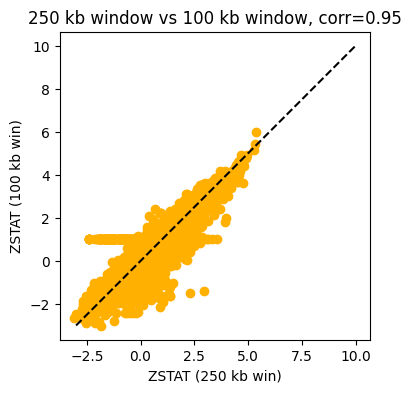

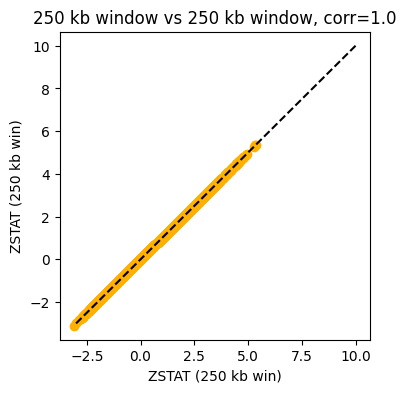

In [148]:
for w in list(loco.keys()):
    for w2 in list(loco.keys()):
        t=loco[w][['GENE','P','ZSTAT']].merge(loco[w2][['GENE','P','ZSTAT']],on='GENE',how='outer').fillna(1)
        corr_plt(t['ZSTAT_x'],t['ZSTAT_y'],'z')
        del(t)

## plot number of genes that are significantly associated

In [95]:
t=loco[0][['GENE','P']].merge(
    loco[1][['GENE','P']],on='GENE',how='outer').merge(
    loco[5][['GENE','P']],on='GENE',how='outer').merge(
    loco[10][['GENE','P']],on='GENE',how='outer').merge(
    loco[25][['GENE','P']],on='GENE',how='outer').merge(
    loco[50][['GENE','P']],on='GENE',how='outer').merge(
    loco[100][['GENE','P']],on='GENE',how='outer').merge(
    loco[250][['GENE','P']],on='GENE',how='outer').fillna(1)
t.columns=['GENE']+list(loco.keys())

/tmp/ipykernel_2360972/1115597819.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'P_x'} in the result is deprecated and will raise a MergeError in a future version.
  t=loco[0][['GENE','P']].merge(
/tmp/ipykernel_2360972/1115597819.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'P_x'} in the result is deprecated and will raise a MergeError in a future version.
  t=loco[0][['GENE','P']].merge(
/tmp/ipykernel_2360972/1115597819.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'P_x'} in the result is deprecated and will raise a MergeError in a future version.
  t=loco[0][['GENE','P']].merge(


In [96]:
n_bonf=[]
n_fdr=[]
n_fdr1=[]
for k in list(loco.keys()):
    loco[k]['Q']=statsmodels.stats.multitest.fdrcorrection(loco[k]['P'],alpha=0.05,method='indep',is_sorted=False)[1]
    n_bonf.append(len(loco[k][loco[k]['P']<0.05/len(loco[k])]['GENE']))
    n_fdr.append(len(loco[k][loco[k]['Q']<0.05]))
    n_fdr1.append(len(loco[k][loco[k]['Q']<0.01]))

In [97]:
sig_genes = pd.DataFrame(
    {'window': list(loco.keys()),
     'n_bonf': n_bonf,
     'n_fdr': n_fdr,
     'n_fdr1': n_fdr1
    })

In [120]:
sig_genes['win_log']=np.log10(sig_genes['window']+1)

In [139]:
save_fig=True

In [136]:
list(map(str,sig_genes.window))

['0', '1', '5', '10', '25', '50', '100', '250']

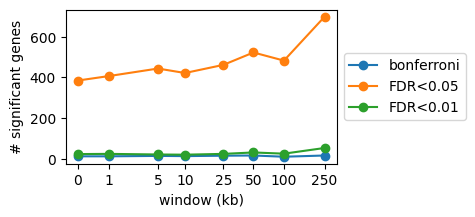

In [141]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(3.5, 2))
ax.plot(sig_genes['win_log'], sig_genes['n_bonf'], marker='o', label='bonferroni')
ax.plot(sig_genes['win_log'], sig_genes['n_fdr'], marker='o', label='FDR<0.05')
ax.plot(sig_genes['win_log'], sig_genes['n_fdr1'], marker='o', label='FDR<0.01')
ax.set_xlabel('window (kb)')
ax.set_ylabel('# significant genes')
#ax.set_xscale('log')
plt.xticks(sig_genes['win_log'],list(map(str,sig_genes.window)))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
if save_fig:
    plt.savefig('figures/loco_magma_win_ngenes.svg',bbox_inches='tight')

# Porcupine functions

In [ ]:
def porcupine(pval, test, pos, chr, label,
              cut_SKAT=5e-8,
              cut_SKATO=5e-8,
              cut_burden=5e-8,
              chrs_plot=None, chrs_names=None,
              cut=2,
              colors=['k', '0.5'],
              title='Title',
              xlabel='chromosome',
              ylabel='-log10(p-value)',
              top=0,
              lines=[10, 15],
              lines_colors=['g', 'r'],
              lines_styles=['-', '--'],
              lines_widths=[1, 1],
              zoom=None,
              scaling='-log10',
              plot_grid_lines=True,
              **kwargs):
    """
    Generates a specialized Porcupine plot for different types of rare-variant SNP to gene tests (SKAT, SKATO, Burden), highlighting significant findings in genomic data using color-coding for test types.

    Parameters:
    - pval (array-like): Array of p-values for genomic variants.
    - test (array-like): Array specifying the type of genetic test performed for each variant p-value.
    - pos (array-like): Array of positions of variants on their respective chromosomes.
    - chr (array-like): Array of chromosome numbers for each variant.
    - label (str): Label for the dataset, used for annotations.
    - cut_SKAT, cut_SKATO, cut_burden (float): Cutoff p-values for SKAT, SKATO, and Burden tests, respectively.
    - chrs_plot (list, optional): Specific chromosomes to include in the plot.
    - chrs_names (list, optional): Custom names for the chromosomes to be plotted.
    - cut (float): Cutoff for -log10(p-value) for displaying points on the plot.
    - colors (list): Colors to use for plotting points, cycling through for different chromosomes.
    - title (str): Title of the plot.
    - xlabel, ylabel (str): Labels for the x-axis and y-axis.
    - top (float): Upper limit for the y-axis; if 0, it is calculated from the data.
    - lines (list): y-values where horizontal lines should be drawn.
    - lines_colors, lines_styles, lines_widths (list): Properties for the horizontal lines.
    - zoom (tuple): Tuple (chromosome, center position, range) for focusing on a specific region.
    - scaling (str): P-value scaling method; supports '-log10' for negative log transformation or 'none'.
    - plot_grid_lines (bool): Whether to include grid lines on the plot.
    - **kwargs: Additional keyword arguments for matplotlib plot functions.

    Returns:
    matplotlib.pyplot: Configured plot object ready for display or saving.
    """
    
    # Initialize plot settings and clear any existing figures
    shift = np.array([0.0])
    plt.clf()

    # Determine which chromosomes to plot, sorting naturally if needed
    if chrs_plot is None:
        chrs_list = np.unique(chr)
        chrs_list = sorted_nicely(chrs_list) if isinstance(chrs_list[0], str) else chrs_list.sort()
    else:
        chrs_list = chrs_plot

    # Generate chromosome labels if not provided
    if chrs_names is None:
        chrs_names = [str(chrs_list[i]) for i in range(len(chrs_list))]

    plot_positions = len(chrs_list) == 1

    # Convert cutoffs to the appropriate scale if necessary
    if scaling == '-log10':
        cut_burden = -np.log10(cut_burden)
        cut_SKATO = -np.log10(cut_SKATO)
        cut_SKAT = -np.log10(cut_SKAT)
        
    # Plot data for each chromosome
    for ii, i in enumerate(chrs_list):     
        plt.subplot(1,1,1)
        filt = np.where(chr == i)[0]
        x = shift[-1] + pos[filt]
        y = -np.log10(pval[filt]) if scaling == '-log10' else pval[filt]
        test_filter = test[filt]
        
        # Plot data points above a general cut-off, with specific colors for each test type. Requires the color_dict to function, or must redefine the color dictionary
        plt.plot(x[y > cut], y[y > cut], '.', color=colors[ii % len(colors)], **kwargs)
        plt.plot(x[(y > cut) & (test_filter == 'Burden') & (y > cut_burden)], y[(y > cut) & (test_filter == 'Burden') & (y > cut_burden)], '.', color=color_dict['Burden'], **kwargs)
        plt.plot(x[(y > cut) & (test_filter == 'SKATO') & (y > cut_SKATO)], y[(y > cut) & (test_filter == 'SKATO') & (y > cut_SKATO)], '.', color=color_dict['SKAT-O'], **kwargs)
        plt.plot(x[(y > cut) & (test_filter == 'SKAT') & (y > cut_SKAT)], y[(y > cut) & (test_filter == 'SKAT') & (y > cut_SKAT)], '.', color=color_dict['SKAT'], **kwargs)

        # Calculate the maximum shift for the next set of points
        shift_f = np.max(x)
        shift_m = 0  # Placeholder for potential future use
        shift = np.append(shift, np.max([shift_f, shift_m]))

        # Set grid lines and limits
        if plot_grid_lines:
            plt.plot([shift[-1], shift[-1]], [0, 1000], '-', lw=0.5, color='lightgray', **kwargs)
        plt.xlim([0, shift[-1]])

    # Determine the upper limit for the y-axis
    if top == 0:
        top = np.ceil(np.max(-np.log10(pval))) if scaling == '-log10' else np.ceil(np.max(pval))

    # Configure fig labels and horizontal lines
    shift_label = shift[-1]
    shift = (shift[1:] + shift[:-1]) / 2
    for i, line_height in enumerate(lines):
        plt.axhline(y=line_height, color=lines_colors[i], linestyle=lines_styles[i], linewidth=lines_widths[i])
    
    plt.ylim([cut, top])
    plt.title(title)
    if not plot_positions:
        plt.xticks(shift, chrs_names)
    plt.text(shift_label * 0.95, top * 0.95, label, verticalalignment='top', horizontalalignment='right')
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

    # Apply zoom settings if specified
    if zoom is not None:
        plt.xlim([zoom_shift - zoom[2], zoom_shift + zoom[2]])

    return plt

In [ ]:
def porcupineplot(self, qtltable: pd.DataFrame(), traitlist: list = [], run_only_qtls = True,
                save_fmt: list = ['html', 'png'], display: bool = True,
                  low_mem = False, childlock = True, qtl_annotation: bool = True, nosmallp: bool = True):
    printwithlog(f'starting porcupineplot ... {self.project_name} reading files')
    samplen = int(1e5) if low_mem else int(5e5) 
    rangen = range(160,180) if low_mem else range(80,90)
    maxtraits = 10
    if len(traitlist) == 0: 
        if run_only_qtls: traitlist = list(qtltable.trait.unique())
        else: traitlist = self.traits
    traitlist = [x.replace("regressedlr_", "") for x in traitlist]
    qtl = qtltable.query('QTL==True')
    df_gwas,df_date = [], []
    for trait_pos, t in tqdm(list(enumerate(traitlist))):
        if childlock == True: childlock_val = np.inf if trait_pos < maxtraits else 0
        for opt in [f'regressedlr_{t.replace("regressedlr_", "")}.loco.mlma', 
                    f'regressedlr_{t.replace("regressedlr_", "")}.mlma']+ \
        [f'regressedlr_{t.replace("regressedlr_", "")}_chrgwas{chromp2}.mlma' for chromp2 in self.chrList()]:
            if glob(f'{self.path}results/gwas/{opt}'): 
                samplenuse = samplen//20 if '_chrgwas' in opt else samplen
                g = pd.read_csv(f'{self.path}results/gwas/{opt}', sep = '\t', dtype = {'Chr': int, 'bp': int}).assign(trait = t)
                g['p'] = g['p'].fillna(1)
                #g=g.applymap(np.nan_to_num)
                g['inv_prob'] = 1/(np.clip(g.p, 1e-6, 1)) 
                if not nosmallp:
                    if  g.query('p > 0.05').shape[0] > 0:
                        gweighted = [g.query('p > 0.05').sample(min(samplenuse, g.query('p > 0.05').shape[0], childlock_val), weights='inv_prob')]
                    else: gweighted = []
                    gweighted += [g[::np.random.choice(rangen)].sample(frac = (trait_pos< maxtraits))]
                else: gweighted =[]
                g = pd.concat([g.query('p < 0.05')]+ gweighted )\
                .sort_values(['Chr', 'bp']).reset_index(drop = True).dropna()
                df_gwas += [g]
                if sum(map(len, df_gwas)) > 1e6: maxtraits = 0
            else: pass
    df_gwas = pd.concat(df_gwas).sort_values(['Chr', 'bp']).reset_index(drop = True)
    
    append_position = df_gwas.groupby('Chr').bp.agg('max').sort_index().cumsum().shift(1,fill_value=0)
    df_gwas['Chromosome'] = df_gwas.apply(lambda row: row.bp + append_position[row.Chr], axis = 1)
    cmap = sns.color_palette("tab10", len(traitlist))
    d = {t: cmap[v] for v,t in enumerate(sorted(traitlist))}
    tnum = {t:num for num,t in enumerate(sorted(traitlist))}
    def mapcolor(c, thresh, p, trait):
        if -np.log10(p)> thresh : return d[trait] 
        elif int(str(c).replace('X',str(self.n_autosome+1)).replace('Y', str(self.n_autosome+2)).replace('MT', str(self.n_autosome+4)))%2 == 0: return 'black'
        return 'gray'
    
    printwithlog(f'starting porcupineplot ... {self.project_name} colorcoding')
    df_gwas['color']= df_gwas.progress_apply(lambda row: mapcolor(row.Chr, self.threshold, row.p, row.trait) ,axis =1)
    df_gwas['annotate'] = (df_gwas.SNP + df_gwas.trait.str.replace('regressedlr_', '') ) .isin(qtl.reset_index().SNP+qtl.reset_index().trait.str.replace('regressedlr_', ''))
    df_gwas.trait = df_gwas.trait.str.replace('regressedlr_', '')
    df_gwas['log10p'] = -np.log10(df_gwas['p'])
    
    fig2 =  go.Figure(data=[])
    fig2.add_scattergl(x = df_gwas['Chromosome'].values,y = -np.log10(df_gwas['p']), name = '', 
                       mode='markers', marker=dict(color=df_gwas.color,line_width=0), showlegend = False)
    for name, ite in tqdm(df_gwas.query('annotate').sort_values('trait').groupby('trait')):
        fig2.add_scattergl(x = ite.Chromosome,y = -np.log10(ite.p),mode='markers',name = f"{name} ({tnum[name]+1})",
                       marker=dict( line_width=1, size = 15, color ='rgb({},{},{})'.format(*ite.color.iloc[0]) ),
                       marker_symbol = 'star-diamond-dot')
    for x in append_position.values: fig2.add_vline(x=x, line_width=1, line_dash="dash", line_color="gray")
    fig2.add_hline(y=self.threshold, line_width=2,  line_color="red")
    fig2.add_hline(y=self.threshold05, line_width=2, line_color="blue")
    if qtl_annotation: 
        showlegend = True
        df_gwas.query('annotate')\
               .apply(lambda x: fig2.add_annotation(x=x.Chromosome, y=-np.log10(x.p),
                                                    text=f"({tnum[x.trait]+1})",showarrow=True,arrowhead=2), axis = 1)
    else:showlegend = True
    if nosmallp:
        # printwithlog('adding lines to porcupineplot')
        temp = df_gwas.query('log10p < 2')
        def add_loli(row):
            return  dict(type = 'line', x0 = row.Chromosome, x1 = row.Chromosome, y0 = 0, y1 =1.32 , line = {'color': row.color, "width": 7, 'dash': 'solid'})
        temp['shapes'] = temp.progress_apply(add_loli, axis = 1)
        temp = temp.assign(rounded = temp.bp.round(-4)).groupby(['Chr', 'rounded']).progress_apply(lambda x: x.nsmallest(1, 'Chromosome'))
        fig2.update_layout(shapes = temp.shapes.to_list())
    printwithlog(f'starting porcupineplot ... {self.project_name} making figure')
    fig2.update_layout(yaxis_range=[0,max(6, -np.log10(df_gwas.p.min())+.5)],
                       xaxis_range = df_gwas.Chromosome.agg(['min', 'max']),
                       template='simple_white',width = 1920, height = 800,  
                       showlegend=showlegend , xaxis_title="Chromosome", yaxis_title="-log10(p)")
    dfgwasgrouped = df_gwas.groupby('Chr')
    fig2.update_xaxes(ticktext = [self.replacenumstoXYMT(names) for names,dfs in dfgwasgrouped],
              tickvals =(append_position + dfgwasgrouped.bp.agg('max').sort_index().cumsum())//2 )
    printwithlog(f'starting porcupineplot ... {self.project_name} saving figure')
    if 'png' in save_fmt: fig2.write_image(f"{self.path}images/porcupineplot.png",width = 1920, height = 800)
    if display: fig2.show(renderer = 'png',width = 1920, height = 800)
    return fig2, df_gwas

def porcupineplotv2(self, qtltable = '', traitlist: list = [], display_figure = False, skip_manhattan = False, maxtraits = 60):
    printwithlog('starting porcupine plot v2')
    hv.opts.defaults(hv.opts.Points(width=1200, height=600), hv.opts.RGB(width=1200, height=600) )
    if type(qtltable) == str:
        if not len(qtltable): qtltable = pd.read_csv(f'{self.path}results/qtls/finalqtl.csv').reset_index().query('QTL == True')
    if not len(traitlist): traitlist = list(map(lambda x:x.replace('regressedlr_', ''),self.traits))        
    cmap = sns.color_palette("tab20", len(traitlist))
    d = {t: cmap[v] for v,t in enumerate(sorted(traitlist))}
    d_inv = {cmap[v]:t for v,t in enumerate(sorted(traitlist))}
    tnum = {t:num for num,t in enumerate(sorted(traitlist))}    
    qtltable['color'] =  qtltable.trait.apply(lambda x: d[x]) 
    qtltable['traitnum'] =  qtltable.trait.apply(lambda x: f'{tnum[x]}') 
    if len(traitlist) > maxtraits: 
        traitlist_new = list(qtltable.trait.unique())
        if maxtraits - len(traitlist_new) > 0:
            traitlist_new += list(np.random.choice(list(set(traitlist) - set(traitlist_new)), maxtraits - len(traitlist_new), replace = False))
    else: traitlist_new = traitlist
    fdf = []
    h2file = pd.read_csv(f'{self.path}results/heritability/heritability.tsv', sep = '\t', index_col = 0).rename(lambda x: x.replace('regressedlr_', ''))
    for num, t in tqdm(list(enumerate(traitlist))):
        if not skip_manhattan or t in traitlist_new:
            df_gwas = []
            for opt in [f'regressedlr_{t.replace("regressedlr_", "")}.loco.mlma', 
                        f'regressedlr_{t.replace("regressedlr_", "")}.mlma']+ \
                       [f'regressedlr_{t.replace("regressedlr_", "")}_chrgwas{chromp2}.mlma' for chromp2 in self.chrList()]:
                if glob(f'{self.path}results/gwas/{opt}'):
                    df_gwas += [pd.read_csv(f'{self.path}results/gwas/{opt}', sep = '\t')]
                else:  pass
            if len(df_gwas) == 0 :  printwithlog(f'could not open mlma files for {t}')
            df_gwas = pd.concat(df_gwas)
            append_position = df_gwas.groupby('Chr').bp.agg('max').sort_index().cumsum().shift(1,fill_value=0)
            qtltable['x'] = qtltable.apply(lambda x: x.bp +  append_position[x.Chr], axis = 1)
            df_gwas['-log10p'] = -np.log10(df_gwas.p)
            df_gwas.drop(['A1', 'A2', 'Freq', 'b', 'se', 'p'], axis = 1, inplace = True)
            def mapcolor(c): 
                if int(str(c).replace('X',str(self.n_autosome+1)).replace('Y', str(self.n_autosome+2)).replace('MT', str(self.n_autosome+4)))%2 == 0: return 'black'
                return 'gray'
            df_gwas = df_gwas.groupby('Chr') \
                             .apply(lambda df: df.assign(color = mapcolor(df.Chr[0]), x = df.bp + append_position[df.Chr[0]])) \
                             .reset_index(drop = True)
            df_gwas.loc[df_gwas['-log10p']> self.threshold, 'color' ] = str(d[t])[1:-1]
            df_gwas.loc[df_gwas['-log10p']> self.threshold, 'color' ] = df_gwas.loc[df_gwas['-log10p']> self.threshold, 'color' ].str.split(',').map(lambda x: tuple(map(float, x)))
            if not skip_manhattan:
                yrange = (-.05,max(6, df_gwas['-log10p'].max()+.5))
                xrange = tuple(df_gwas.x.agg(['min', 'max'])+ np.array([-1e7,+1e7]))
                fig = []
                for idx, dfs in df_gwas[df_gwas.color.isin(['gray', 'black'])].groupby('color'):
                    temp = datashade(hv.Points(dfs, kdims = ['x','-log10p']), pixel_ratio= 2, aggregator=ds.count(), width = 1200,height = 600, y_range= yrange,
                             min_alpha=.7, cmap = [idx], dynamic = False )
                    temp = dynspread(temp, max_px=4,threshold= 1 )
                    fig += [temp]
                fig = fig[0]*fig[1]
                fig = fig*hv.HLine((self.threshold05)).opts(color='blue')*hv.HLine(self.threshold).opts(color='red')
                fig = fig*hv.Points(df_gwas[df_gwas['-log10p']> self.threshold].drop('color', axis = 1), 
                                    kdims = ['x','-log10p']).opts(color = 'red', size = 5)
                figh2 = round(h2file.loc[t.replace("regressedlr_", ""),'V(G)/Vp'],3)
                fig = fig.opts(xticks=[((dfs.x.agg(['min', 'max'])).sum()//2 , self.replacenumstoXYMT(names)) for names,dfs in  df_gwas.groupby('Chr')],
                                               xlim =xrange, ylim=yrange, width = 1200,height = 600,  xlabel='Chromosome',
                               title = f'{t.replace("regressedlr_", "")} n={self.df["regressedlr_"+ t.replace("regressedlr_", "")].count()} h2={figh2}') 
                hv.save(fig, f'{self.path}images/manhattan/{t.replace("regressedlr_", "")}.png')
            if t in traitlist_new: fdf += [df_gwas]
    fdf = pd.concat(fdf).reset_index(drop = True).sort_values('x')
    fig = []
    yrange = (-.05,max(6, fdf['-log10p'].max()+.5))
    xrange = tuple(fdf.x.agg(['min', 'max'])+ np.array([-1e7,+1e7]))
    for idx, dfs in fdf[fdf.color.isin(['gray', 'black'])].groupby('color'):
        temp = datashade(hv.Points(dfs, kdims = ['x','-log10p']), pixel_ratio= 2, aggregator=ds.count(), width = 1200,height = 600, y_range= yrange,
                 min_alpha=.7, cmap = [idx], dynamic = False )
        temp = dynspread(temp, max_px=4,threshold= 1 )
        fig += [temp]
    fig = fig[0]*fig[1]
    
    fig = fig*hv.HLine((self.threshold05)).opts(color='blue')
    fig = fig*hv.HLine(self.threshold).opts(color='red')
    
    for idx, dfs in fdf[~fdf.color.isin(['gray', 'black'])].groupby('color'):
        fig = fig*hv.Points(dfs.drop('color', axis = 1), kdims = ['x','-log10p']).opts(color = idx, size = 5)
    
    for t, dfs in qtltable.groupby('trait'):
        fig = fig*hv.Points(dfs.assign(**{'-log10p': qtltable.p}), kdims = ['x','-log10p'],vdims=[ 'trait','SNP' ,'A1','A2','Freq' ,'b','traitnum'], label = f'({tnum[t]}) {t}' ) \
                                      .opts(size = 17, color = d[t], marker='inverted_triangle', line_color = 'black', tools=['hover']) #
    fig = fig*hv.Labels(qtltable.rename({'p':'-log10p'}, axis = 1)[['x', '-log10p', 'traitnum']], 
                        ['x','-log10p'],vdims=['traitnum']).opts(text_font_size='5pt', text_color='black')
    fig.opts(xticks=[((dfs.x.agg(['min', 'max'])).sum()//2 , self.replacenumstoXYMT(names)) for names, dfs in fdf.groupby('Chr')],
                               xlim =xrange, ylim=yrange, xlabel='Chromosome', shared_axes=False,
                           width=1200, height=600, title = f'porcupineplot',legend_position='right',show_legend=True)
    hv.save(fig, f'{self.path}images/porcupineplot.png')
    if display_figure: 
        display(fig)
        return
    return fig
